In [1]:
import importlib
import time
import os
import pickle
import glob
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
# tune_name = 'dense_obs'

# # save_dir = 'RK_tune'
# save_dir = 'dt_05_2'

tune_name = 'e2'

save_dir = 'dt_05_2'

home = os.path.expanduser("~")

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)

tune_dir = os.path.join(save_dir, tune_name)

stdrd_dir = os.path.join(tune_dir, 'stdrd_loc')
smooth_dir = os.path.join(tune_dir, 'smooth_loc')
smooth_Pl_dir = os.path.join(tune_dir, 'smooth_loc_Pl')


this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 'Z0_ens.npy')
Z0ens = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

# this_path = os.path.join(save_dir, 't_lr.npy')
# t_lr = np.load(this_path)

this_path = os.path.join(save_dir, 'run_vars.pkl')
with open(this_path, mode='rb') as f:
    run_vars = pickle.load(f)

In [6]:
for key, value in run_vars.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')

Nz = 960
K = 32
I = 12
F = 14.0
b = 1.0
c = 0.37
alpha = 0.12414383561643835
beta = 0.013746194824961947
coarse = 8
Nez = 20
Nex = 500
dt_rk = 0.0020833333333333333
dt_lr = 0.1
dt_gt = 0.0020833333333333333
Tic = 24.0
Tlr = 4000
Tgt = 250


In [7]:
# if not os.path.exists(tune_dir):
#     os.mkdir(tune_dir)

# dt_trial_rk = 0.05/24
# dt_kf = 0.05
# dt_save = None
# Tkf = Tgt/5     #### Change this
# Tspin_index = 500
# Tspin = dt_kf * Tspin_index

# alpha_range = np.array([0, 0.01, 0.02, 0.04, 0.08], dtype='float')
# loc_range = np.array([5, 10, 15, 20, 30, 40, 50, 60], dtype='float')


# R_sd = 2
# everyH = 24
# Hz = np.eye(Nz)[::everyH]
# Ny = Hz.shape[0]
# Rz = np.eye(Ny) * R_sd**2

# fine_obs_dict = {'dt_trial_rk': dt_trial_rk,
#                  'dt_kf': dt_kf,
#                  'dt_save': dt_save,
#                  'Tkf': Tkf,
#                  'Tspin': Tspin,
#                  'alpha_range': alpha_range,
#                  'loc_range': loc_range,
#                  'R_sd': R_sd,
#                  'Hz': Hz,
#                  'Rz': Rz}

this_path = os.path.join(tune_dir, 'coarse_obs_dict.pkl')
with open(this_path, mode='rb') as f:
    fine_obs_dict = pickle.load(f)

for key, value in fine_obs_dict.items():
    print(key + ' = ' + str(value))
    exec(key + '=value')
    
Ny = Hz.shape[0]
Rz = np.eye(Ny)

del alpha_range, loc_range

Tspin_index = int(Tspin/dt_kf)

dt_trial_rk = 0.0020833333333333333
dt_kf = 0.05
dt_save = None
Tkf = 50.0
Tspin = 25.0
alpha_range = [0.   0.05 0.1  0.15 0.2  0.25 0.3 ]
loc_range = [ 2.  5. 10. 15. 20. 25. 30. 35. 40.]
R_sd = 0.3
everyH = 2
Hz = [[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Rz = [[0.09 0.   0.   ... 0.   0.   0.  ]
 [0.   0.09 0.   ... 0.   0.   0.  ]
 [0.   0.   0.09 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.09 0.   0.  ]
 [0.   0.   0.   ... 0.   0.09 0.  ]
 [0.   0.   0.   ... 0.   0.   0.09]]


In [8]:
dt_kf = 0.05
Tkf = 100
Tspin = 25.0

In [9]:
Nobs = int(Tkf/dt_kf) + 1
t_kf = np.linspace(0, Tkf, Nobs)

Ngt = int(Tgt/dt_gt) + 1
t_gt = np.linspace(0, Tgt, Ngt)
index_Tkf = int(Tkf/dt_gt) + 1

every_t = int(dt_kf/dt_gt)

if not np.allclose(t_kf, t_gt[0:index_Tkf:every_t]):
    print('They do not match')

In [10]:
Zloc = np.arange(Nz)

Zgt = Zgt[:, 0:index_Tkf:every_t]

Zgt_ts = xr.DataArray(Zgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})
Zobs_ts = Zgt[::everyH]
Zobs_ts = xr.DataArray(Zobs_ts,
                       dims=('loc', 'time'),
                       coords={'loc': Zloc[::everyH],
                               'time': t_kf})

In [11]:
Xgt = utilities.window_sum_Z(Zgt, I=I, alpha=alpha, beta=beta)
Ygt = Zgt - Xgt

Xgt_ts = xr.DataArray(Xgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})

Ygt_ts = xr.DataArray(Ygt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_kf})

In [12]:
search_path = os.path.join(smooth_dir, 'inf_????_smooth_????_floc_????_cloc_????')
smooth_dirs = glob.glob(search_path)

In [13]:
# search_path = os.path.join(smooth_dir, 'inf_????_smooth_0999_floc_????_cloc_????')
search_path = os.path.join(smooth_dir, 'inf_????_smooth_????_floc_????_cloc_????')
smooth_dirs = glob.glob(search_path)
smooth_dirs.sort()

smooth_dirs_success = []

smooth_rmse_f = []
smooth_rmse_a = []

smooth_ratio_f = []
smooth_ratio_a = []

smooth_rmse_fX = []
smooth_rmse_aX = []

smooth_rmse_fY = []
smooth_rmse_aY = []

smooth_std_f = []
smooth_std_a = []

smooth_alpha = []
smooth_cloc = []
smooth_floc = []
smooth_smooth = []
for this_dir in smooth_dirs:
    print(os.path.split(this_dir)[1])
    try:
        this_path = os.path.join(this_dir, 'mu_f.nc')
        temp_mu_f = xr.open_dataarray(this_path)

        temp_mu_fX = utilities.window_sum_Z(temp_mu_f, I=I, alpha=alpha, beta=beta)
        temp_mu_fY = temp_mu_f - temp_mu_fX

        this_path = os.path.join(this_dir, 'mu_a.nc')
        temp_mu_a = xr.open_dataarray(this_path)

        temp_mu_aX = utilities.window_sum_Z(temp_mu_a, I=I, alpha=alpha, beta=beta)
        temp_mu_aY = temp_mu_a - temp_mu_aX

        this_path = os.path.join(this_dir, 'alpha.npy')
        smooth_alpha.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0c.npy')
        smooth_cloc.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0f.npy')
        smooth_floc.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'smooth.npy')
        smooth_smooth.append(np.load(this_path).item())
        print(np.load(this_path).item())

#         temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#         smooth_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
#         temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#         smooth_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())

#         smooth_rmse_fX.append(np.sqrt(
#             ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_rmse_aX.append(np.sqrt(
#             ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         smooth_rmse_fY.append(np.sqrt(
#             ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_rmse_aY.append(np.sqrt(
#             ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)
#         temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)
#         temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))

#         smooth_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())

#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f

#         smooth_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())




        temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
        smooth_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
        temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
        smooth_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())

#         temp_rmse_f = np.abs(temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))
#         temp_rmse_a = np.abs(temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))

        smooth_rmse_fX.append(np.sqrt(
            ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        smooth_rmse_aX.append(np.sqrt(
            ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        smooth_rmse_fY.append(np.sqrt(
            ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        smooth_rmse_aY.append(np.sqrt(
            ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        this_path = os.path.join(this_dir, 'std_f.nc')
        temp_std_f = xr.open_dataarray(this_path)
        temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

        this_path = os.path.join(this_dir, 'std_a.nc')
        temp_std_a = xr.open_dataarray(this_path)
        temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))

        smooth_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
        smooth_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())

#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)

#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f

#         smooth_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        temp_ratio_a = temp_rmse_a/temp_std_a
        temp_ratio_f = temp_rmse_f/temp_std_f
        smooth_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
        smooth_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        
        smooth_dirs_success.append(this_dir)
    except:
        print('failed')
        
smooth_dirs_success = np.array(smooth_dirs_success)

smooth_alpha = np.array(smooth_alpha)
smooth_cloc = np.array(smooth_cloc)
smooth_floc = np.array(smooth_floc)
smooth_smooth = np.array(smooth_smooth)

smooth_rmse_f = np.array(smooth_rmse_f)
smooth_rmse_a = np.array(smooth_rmse_a)

smooth_rmse_fX = np.array(smooth_rmse_fX)
smooth_rmse_aX = np.array(smooth_rmse_aX)

smooth_rmse_fY = np.array(smooth_rmse_fY)
smooth_rmse_aY = np.array(smooth_rmse_aY)

smooth_ratio_f = np.array(smooth_ratio_f)
smooth_ratio_a = np.array(smooth_ratio_a)

inf_0001_smooth_0000_floc_0000_cloc_0000
4
inf_0001_smooth_0000_floc_0000_cloc_0001
4
inf_0001_smooth_0000_floc_0000_cloc_0002
4
inf_0001_smooth_0000_floc_0000_cloc_0003
4
inf_0001_smooth_0000_floc_0001_cloc_0000
4
inf_0001_smooth_0000_floc_0001_cloc_0001
4
inf_0001_smooth_0000_floc_0001_cloc_0002
4
inf_0001_smooth_0000_floc_0001_cloc_0003
4
inf_0001_smooth_0000_floc_0002_cloc_0000
4
inf_0001_smooth_0000_floc_0002_cloc_0001
4
inf_0001_smooth_0000_floc_0002_cloc_0002
4
inf_0001_smooth_0000_floc_0002_cloc_0003
4
inf_0001_smooth_0000_floc_0003_cloc_0000
4
inf_0001_smooth_0000_floc_0003_cloc_0001
4
inf_0001_smooth_0000_floc_0003_cloc_0002
4
inf_0001_smooth_0000_floc_0003_cloc_0003
4
inf_0001_smooth_0001_floc_0000_cloc_0000
8
inf_0001_smooth_0001_floc_0000_cloc_0001
8
inf_0001_smooth_0001_floc_0000_cloc_0002
8
inf_0001_smooth_0001_floc_0000_cloc_0003
8
inf_0001_smooth_0001_floc_0001_cloc_0000
8
inf_0001_smooth_0001_floc_0001_cloc_0001
8
inf_0001_smooth_0001_floc_0001_cloc_0002
8
inf_0001_sm

In [32]:
# search_path = os.path.join(smooth_dir, 'inf_????_smooth_0999_floc_????_cloc_????')
search_path = os.path.join(smooth_Pl_dir, 'inf_????_smooth_????_cloc_????')
smooth_Pl_dirs = glob.glob(search_path)
smooth_Pl_dirs.sort()

smooth_Pl_dirs_success = []

smooth_Pl_rmse_f = []
smooth_Pl_rmse_a = []

smooth_Pl_ratio_f = []
smooth_Pl_ratio_a = []

smooth_Pl_rmse_fX = []
smooth_Pl_rmse_aX = []

smooth_Pl_rmse_fY = []
smooth_Pl_rmse_aY = []

smooth_Pl_std_f = []
smooth_Pl_std_a = []

smooth_Pl_alpha = []
smooth_Pl_cloc = []
smooth_Pl_floc = []
smooth_Pl_smooth = []
for this_dir in smooth_Pl_dirs:
    print(os.path.split(this_dir)[1])
    try:
        this_path = os.path.join(this_dir, 'mu_f.nc')
        temp_mu_f = xr.open_dataarray(this_path)

        temp_mu_fX = utilities.window_sum_Z(temp_mu_f, I=I, alpha=alpha, beta=beta)
        temp_mu_fY = temp_mu_f - temp_mu_fX

        this_path = os.path.join(this_dir, 'mu_a.nc')
        temp_mu_a = xr.open_dataarray(this_path)

        temp_mu_aX = utilities.window_sum_Z(temp_mu_a, I=I, alpha=alpha, beta=beta)
        temp_mu_aY = temp_mu_a - temp_mu_aX

        this_path = os.path.join(this_dir, 'alpha.npy')
        smooth_Pl_alpha.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0c.npy')
        smooth_Pl_cloc.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'smooth.npy')
        smooth_Pl_smooth.append(np.load(this_path).item())
        print(np.load(this_path).item())

#         temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#         smooth_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
#         temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#         smooth_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())

#         smooth_rmse_fX.append(np.sqrt(
#             ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_rmse_aX.append(np.sqrt(
#             ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         smooth_rmse_fY.append(np.sqrt(
#             ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_rmse_aY.append(np.sqrt(
#             ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)
#         temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)
#         temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))

#         smooth_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())

#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f

#         smooth_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())




        temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
        smooth_Pl_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
        temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
        smooth_Pl_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())

#         temp_rmse_f = np.abs(temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))
#         temp_rmse_a = np.abs(temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))

        smooth_Pl_rmse_fX.append(np.sqrt(
            ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        smooth_Pl_rmse_aX.append(np.sqrt(
            ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        smooth_Pl_rmse_fY.append(np.sqrt(
            ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        smooth_Pl_rmse_aY.append(np.sqrt(
            ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        this_path = os.path.join(this_dir, 'std_f.nc')
        temp_std_f = xr.open_dataarray(this_path)
        temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

        this_path = os.path.join(this_dir, 'std_a.nc')
        temp_std_a = xr.open_dataarray(this_path)
        temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))

        smooth_Pl_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
        smooth_Pl_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())

#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)

#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f

#         smooth_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         smooth_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        temp_ratio_a = temp_rmse_a/temp_std_a
        temp_ratio_f = temp_rmse_f/temp_std_f
        smooth_Pl_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
        smooth_Pl_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        
        smooth_Pl_dirs_success.append(this_dir)
    except:
        print('failed')
        
smooth_Pl_dirs_success = np.array(smooth_dirs_success)

smooth_Pl_alpha = np.array(smooth_Pl_alpha)
smooth_Pl_cloc = np.array(smooth_Pl_cloc)
smooth_Pl_smooth = np.array(smooth_Pl_smooth)

smooth_Pl_rmse_f = np.array(smooth_Pl_rmse_f)
smooth_Pl_rmse_a = np.array(smooth_Pl_rmse_a)

smooth_Pl_rmse_fX = np.array(smooth_Pl_rmse_fX)
smooth_Pl_rmse_aX = np.array(smooth_Pl_rmse_aX)

smooth_Pl_rmse_fY = np.array(smooth_Pl_rmse_fY)
smooth_Pl_rmse_aY = np.array(smooth_Pl_rmse_aY)

smooth_Pl_ratio_f = np.array(smooth_Pl_ratio_f)
smooth_Pl_ratio_a = np.array(smooth_Pl_ratio_a)

inf_0002_smooth_0000_cloc_0000
4
inf_0002_smooth_0000_cloc_0001
4
inf_0002_smooth_0000_cloc_0002
4
inf_0002_smooth_0000_cloc_0003
4
inf_0002_smooth_0001_cloc_0000
8
inf_0002_smooth_0001_cloc_0001
8
inf_0002_smooth_0001_cloc_0002
8
inf_0002_smooth_0001_cloc_0003
8
inf_0002_smooth_0002_cloc_0000
12
inf_0002_smooth_0002_cloc_0001
12
inf_0002_smooth_0002_cloc_0002
12
inf_0002_smooth_0002_cloc_0003
12
inf_0002_smooth_0003_cloc_0000
16
inf_0002_smooth_0003_cloc_0001
16
inf_0002_smooth_0003_cloc_0002
16
inf_0002_smooth_0003_cloc_0003
16


In [15]:
search_path = os.path.join(stdrd_dir, 'inf_????_loc_????')
stdrd_dirs = glob.glob(search_path)
stdrd_dirs.sort()

stdrd_dirs_success = []

stdrd_rmse_f = []
stdrd_rmse_a = []

stdrd_ratio_f = []
stdrd_ratio_a = []

stdrd_rmse_fX = []
stdrd_rmse_aX = []

stdrd_rmse_fY = []
stdrd_rmse_aY = []

stdrd_std_f = []
stdrd_std_a = []

stdrd_alpha = []
stdrd_loc = []
for this_dir in stdrd_dirs:
    print(os.path.split(this_dir)[1])
    try:
        this_path = os.path.join(this_dir, 'mu_f.nc')
        temp_mu_f = xr.open_dataarray(this_path)

        temp_mu_fX = utilities.window_sum_Z(temp_mu_f, I=I, alpha=alpha, beta=beta)
        temp_mu_fY = temp_mu_f - temp_mu_fX

        this_path = os.path.join(this_dir, 'mu_a.nc')
        temp_mu_a = xr.open_dataarray(this_path)

        temp_mu_aX = utilities.window_sum_Z(temp_mu_a, I=I, alpha=alpha, beta=beta)
        temp_mu_aY = temp_mu_a - temp_mu_aX
        
        this_path = os.path.join(this_dir, 'alpha.npy')
        stdrd_alpha.append(np.load(this_path).item())

        this_path = os.path.join(this_dir, 'rho0z.npy')
        stdrd_loc.append(np.load(this_path).item())
        
        
#         temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#         stdrd_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
#         temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#         stdrd_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())

#         stdrd_rmse_fX.append(np.sqrt(
#             ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         stdrd_rmse_aX.append(np.sqrt(
#             ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         stdrd_rmse_fY.append(np.sqrt(
#             ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())
#         stdrd_rmse_aY.append(np.sqrt(
#             ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
#                                       .isel(time=slice(Tspin_index, None)).mean().item())

#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)
#         temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)
#         temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))
        
#         stdrd_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
#         stdrd_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())
        
#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f
        
#         stdrd_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         stdrd_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        
        
        
        
        
        temp_rmse_f = np.sqrt(((temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
        stdrd_rmse_f.append(temp_rmse_f.isel(time=slice(Tspin_index, None)).mean().item())
        temp_rmse_a = np.sqrt(((temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
        stdrd_rmse_a.append(temp_rmse_a.isel(time=slice(Tspin_index, None)).mean().item())
        
#         temp_rmse_f = np.abs(temp_mu_f - Zgt_ts.sel(time=temp_mu_f.time))
#         temp_rmse_a = np.abs(temp_mu_a - Zgt_ts.sel(time=temp_mu_a.time))

        stdrd_rmse_fX.append(np.sqrt(
            ((temp_mu_fX - Xgt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_rmse_aX.append(np.sqrt(
            ((temp_mu_aX - Xgt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        stdrd_rmse_fY.append(np.sqrt(
            ((temp_mu_fY - Ygt_ts.sel(time=temp_mu_f.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_rmse_aY.append(np.sqrt(
            ((temp_mu_aY - Ygt_ts.sel(time=temp_mu_a.time))**2).mean(axis=0))
                                      .isel(time=slice(Tspin_index, None)).mean().item())

        this_path = os.path.join(this_dir, 'std_f.nc')
        temp_std_f = xr.open_dataarray(this_path)
        temp_std_f = np.sqrt((temp_std_f**2).mean(axis=0))

        this_path = os.path.join(this_dir, 'std_a.nc')
        temp_std_a = xr.open_dataarray(this_path)
        temp_std_a = np.sqrt((temp_std_a**2).mean(axis=0))
        
        stdrd_std_f.append(temp_std_f.isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_std_a.append(temp_std_a.isel(time=slice(Tspin_index, None)).mean().item())
        
#         this_path = os.path.join(this_dir, 'std_f.nc')
#         temp_std_f = xr.open_dataarray(this_path)

#         this_path = os.path.join(this_dir, 'std_a.nc')
#         temp_std_a = xr.open_dataarray(this_path)
        
#         temp_ratio_a = temp_rmse_a/temp_std_a
#         temp_ratio_f = temp_rmse_f/temp_std_f
        
#         stdrd_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
#         stdrd_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        
        temp_ratio_a = temp_rmse_a/temp_std_a
        temp_ratio_f = temp_rmse_f/temp_std_f
        stdrd_ratio_a.append(temp_ratio_a.isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_ratio_f.append(temp_ratio_f.isel(time=slice(Tspin_index, None)).mean().item())
        stdrd_dirs_success.append(this_dir)
    except:
        print('failed')
        
stdrd_dirs_success = np.array(stdrd_dirs_success)
stdrd_alpha = np.array(stdrd_alpha)
stdrd_loc = np.array(stdrd_loc)

stdrd_rmse_f = np.array(stdrd_rmse_f)
stdrd_rmse_a = np.array(stdrd_rmse_a)

stdrd_rmse_fX = np.array(stdrd_rmse_fX)
stdrd_rmse_aX = np.array(stdrd_rmse_aX)

stdrd_rmse_fY = np.array(stdrd_rmse_fY)
stdrd_rmse_aY = np.array(stdrd_rmse_aY)

stdrd_ratio_a = np.array(stdrd_ratio_a)
stdrd_ratio_f = np.array(stdrd_ratio_f)

inf_0000_loc_0000
inf_0000_loc_0001
inf_0000_loc_0002
inf_0000_loc_0003
inf_0000_loc_0004
inf_0000_loc_0005
inf_0000_loc_0006
inf_0000_loc_0007
inf_0000_loc_0008
inf_0001_loc_0000
inf_0001_loc_0001
inf_0001_loc_0002
failed
inf_0001_loc_0003
inf_0001_loc_0004
inf_0001_loc_0005
inf_0001_loc_0006
inf_0001_loc_0007
inf_0001_loc_0008
inf_0002_loc_0000
inf_0002_loc_0001
inf_0002_loc_0002
inf_0002_loc_0003
inf_0002_loc_0004
inf_0002_loc_0005
inf_0002_loc_0006
inf_0002_loc_0007
inf_0002_loc_0008
inf_0003_loc_0000
inf_0003_loc_0001
inf_0003_loc_0002
inf_0003_loc_0003
inf_0003_loc_0004
inf_0003_loc_0005
inf_0003_loc_0006
inf_0003_loc_0007
inf_0003_loc_0008
inf_0004_loc_0000
inf_0004_loc_0001
inf_0004_loc_0002
inf_0004_loc_0003
inf_0004_loc_0004
inf_0004_loc_0005
inf_0004_loc_0006
inf_0004_loc_0007
inf_0004_loc_0008
inf_0005_loc_0000
inf_0005_loc_0001
inf_0005_loc_0002
inf_0005_loc_0003
inf_0005_loc_0004
inf_0005_loc_0005
inf_0005_loc_0006
inf_0005_loc_0007
inf_0005_loc_0008
inf_0006_loc_0000
inf

In [16]:
print('Unique parameters for standard localization:')
print(f'Inflation: {np.unique(stdrd_alpha)}')
print(f'localization: {np.unique(stdrd_loc)}')
print()
print('Unique parameters of smoothing localization:')
print(f'Inflation: {np.unique(smooth_alpha)}')
print(f'Fine localization: {np.unique(smooth_floc)}')
print(f'Coarse localization: {np.unique(smooth_cloc)}')
print(f'Smoothing distance: {np.unique(smooth_smooth)}')

Unique parameters for standard localization:
Inflation: [0.   0.05 0.1  0.15 0.2  0.25 0.3 ]
localization: [ 2.  5. 10. 15. 20. 25. 30. 35. 40.]

Unique parameters of smoothing localization:
Inflation: [0.   0.05 0.1 ]
Fine localization: [ 2  4  6  8 10 12]
Coarse localization: [10 20 30 40]
Smoothing distance: [ 4  8 12 16]


In [17]:
smooth_index_a = np.argmin(np.abs(smooth_ratio_a - 1))
stdrd_index_a = np.argmin(np.abs(stdrd_ratio_a - 1))

print()
print('When Z analysis ratio is optimized:', '\n')
print('Smoothing method: ')
print(f'Analysis ratio of: {smooth_ratio_a[smooth_index_a]:0.4}')
print(f'Forecast ratio of: {smooth_ratio_f[smooth_index_a]:0.4}')
print(f'Anlysis rmse of: {smooth_rmse_a[smooth_index_a]:0.4}')
print(f'Forecast rmse of: {smooth_rmse_f[smooth_index_a]:0.4}')
print(f'Anlysis (X) rmse of: {smooth_rmse_aX[smooth_index_a]:0.4}')
print(f'Forecast (X) rmse of: {smooth_rmse_fX[smooth_index_a]:0.4}')
print(f'Anlysis (Y) rmse of: {smooth_rmse_aY[smooth_index_a]:0.4}')
print(f'Forecast (Y) rmse of: {smooth_rmse_fY[smooth_index_a]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_a]}')
print(f'fine loc: {smooth_floc[smooth_index_a]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_a]}')
print(f'alpha: {smooth_alpha[smooth_index_a]}')

print()
print('Standard method: ')
print(f'Analysis ratio of: {stdrd_ratio_a[stdrd_index_a]:0.4}')
print(f'Forecast ratio of: {stdrd_ratio_f[stdrd_index_a]:0.4}')
print(f'Anlysis rmse of: {stdrd_rmse_a[stdrd_index_a]:0.4}')
print(f'Forecast rmse of: {stdrd_rmse_f[stdrd_index_a]:0.4}')
print(f'Anlysis (X) rmse of: {stdrd_rmse_aX[stdrd_index_a]:0.4}')
print(f'Forecast (X) rmse of: {stdrd_rmse_fX[stdrd_index_a]:0.4}')
print(f'Anlysis (Y) rmse of: {stdrd_rmse_aY[stdrd_index_a]:0.4}')
print(f'Forecast (Y) rmse of: {stdrd_rmse_fY[stdrd_index_a]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_a]}')
print(f'alpha: {stdrd_alpha[stdrd_index_a]}')

sm_rf = smooth_ratio_f[smooth_index_a]
sm_ra = smooth_ratio_a[smooth_index_a]

sm_f = smooth_rmse_f[smooth_index_a]
sm_a = smooth_rmse_a[smooth_index_a]

stdrd_f = stdrd_rmse_f[stdrd_index_a]
stdrd_a = stdrd_rmse_a[stdrd_index_a]

stdrd_rf = stdrd_ratio_f[stdrd_index_a]
stdrd_ra = stdrd_ratio_a[stdrd_index_a]

sm_fX = smooth_rmse_fX[smooth_index_a]
sm_aX = smooth_rmse_aX[smooth_index_a]

stdrd_fX = stdrd_rmse_fX[stdrd_index_a]
stdrd_aX = stdrd_rmse_aX[stdrd_index_a]

sm_fY = smooth_rmse_fY[smooth_index_a]
sm_aY = smooth_rmse_aY[smooth_index_a]

stdrd_fY = stdrd_rmse_fY[stdrd_index_a]
stdrd_aY = stdrd_rmse_aY[stdrd_index_a]
print()
print(f'This is a {100*((np.abs(1 - stdrd_rf) - np.abs(1 - sm_rf))/np.abs(1 - stdrd_rf)):0.2f}% improvement for forecasts ratio')
print(f'This is a {100*((np.abs(1 - stdrd_ra) - np.abs(1 - sm_ra))/np.abs(1 - stdrd_ra)):0.2f}% improvement for analysis ratio')

print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

print(f'This is a {100*(stdrd_fX - sm_fX)/(stdrd_fX):0.2f}% improvement for X forecasts')
print(f'This is a {100*(stdrd_aX - sm_aX)/(stdrd_aX):0.2f}% improvement for X analysis')

print(f'This is a {100*(stdrd_fY - sm_fY)/(stdrd_fY):0.2f}% improvement for Y forecasts')
print(f'This is a {100*(stdrd_aY - sm_aY)/(stdrd_aY):0.2f}% improvement for Y analysis')


When Z analysis ratio is optimized: 

Smoothing method: 
Analysis ratio of: 0.9987
Forecast ratio of: 1.005
Anlysis rmse of: 0.06131
Forecast rmse of: 0.06552
Anlysis (X) rmse of: 0.03297
Forecast (X) rmse of: 0.03544
Anlysis (Y) rmse of: 0.04976
Forecast (Y) rmse of: 0.05301
With coarse loc: 30
fine loc: 6
smoothing dist: 16
alpha: 0.05

Standard method: 
Analysis ratio of: 0.9973
Forecast ratio of: 1.002
Anlysis rmse of: 0.07034
Forecast rmse of: 0.07476
Anlysis (X) rmse of: 0.03566
Forecast (X) rmse of: 0.03807
Anlysis (Y) rmse of: 0.05844
Forecast (Y) rmse of: 0.06201
With loc: 10.0
alpha: 0.1

This is a -131.62% improvement for forecasts ratio
This is a 53.34% improvement for analysis ratio
This is a 12.37% improvement for forecasts
This is a 12.83% improvement for analysis
This is a 6.93% improvement for X forecasts
This is a 7.55% improvement for X analysis
This is a 14.52% improvement for Y forecasts
This is a 14.85% improvement for Y analysis


In [18]:
smooth_index_f = np.argmin(np.abs(smooth_ratio_f - 1))
stdrd_index_f = np.argmin(np.abs(stdrd_ratio_f - 1))

print()
print('When Z forecast ratio is optimized:', '\n')
print('Smoothing method: ')
print(f'Analysis ratio of: {smooth_ratio_a[smooth_index_f]:0.4}')
print(f'Forecast ratio of: {smooth_ratio_f[smooth_index_f]:0.4}')
print(f'Anlysis rmse of: {smooth_rmse_a[smooth_index_f]:0.4}')
print(f'Forecast rmse of: {smooth_rmse_f[smooth_index_f]:0.4}')
print(f'Anlysis (X) rmse of: {smooth_rmse_aX[smooth_index_f]:0.4}')
print(f'Forecast (X) rmse of: {smooth_rmse_fX[smooth_index_f]:0.4}')
print(f'Anlysis (Y) rmse of: {smooth_rmse_aY[smooth_index_f]:0.4}')
print(f'Forecast (Y) rmse of: {smooth_rmse_fY[smooth_index_f]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_f]}')
print(f'fine loc: {smooth_floc[smooth_index_f]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_f]}')
print(f'alpha: {smooth_alpha[smooth_index_f]}')

print()
print('Standard method: ')
print(f'Analysis ratio of: {stdrd_ratio_a[stdrd_index_f]:0.4}')
print(f'Forecast ratio of: {stdrd_ratio_f[stdrd_index_f]:0.4}')
print(f'Anlysis rmse of: {stdrd_rmse_a[stdrd_index_f]:0.4}')
print(f'Forecast rmse of: {stdrd_rmse_f[stdrd_index_f]:0.4}')
print(f'Anlysis (X) rmse of: {stdrd_rmse_aX[stdrd_index_f]:0.4}')
print(f'Forecast (X) rmse of: {stdrd_rmse_fX[stdrd_index_f]:0.4}')
print(f'Anlysis (Y) rmse of: {stdrd_rmse_aY[stdrd_index_f]:0.4}')
print(f'Forecast (Y) rmse of: {stdrd_rmse_fY[stdrd_index_f]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_f]}')
print(f'alpha: {stdrd_alpha[stdrd_index_f]}')

sm_rf = smooth_ratio_f[smooth_index_f]
sm_ra = smooth_ratio_a[smooth_index_f]

sm_f = smooth_rmse_f[smooth_index_f]
sm_a = smooth_rmse_a[smooth_index_f]

stdrd_f = stdrd_rmse_f[stdrd_index_f]
stdrd_a = stdrd_rmse_a[stdrd_index_f]

stdrd_rf = stdrd_ratio_f[stdrd_index_f]
stdrd_ra = stdrd_ratio_a[stdrd_index_f]

sm_fX = smooth_rmse_fX[smooth_index_f]
sm_aX = smooth_rmse_aX[smooth_index_f]

stdrd_fX = stdrd_rmse_fX[stdrd_index_f]
stdrd_aX = stdrd_rmse_aX[stdrd_index_f]

sm_fY = smooth_rmse_fY[smooth_index_f]
sm_aY = smooth_rmse_aY[smooth_index_f]

stdrd_fY = stdrd_rmse_fY[stdrd_index_f]
stdrd_aY = stdrd_rmse_aY[stdrd_index_f]
print()
print(f'This is a {100*((np.abs(1 - stdrd_rf) - np.abs(1 - sm_rf))/np.abs(1 - stdrd_rf)):0.2f}% improvement for forecasts ratio')
print(f'This is a {100*((np.abs(1 - stdrd_ra) - np.abs(1 - sm_ra))/np.abs(1 - stdrd_ra)):0.2f}% improvement for analysis ratio')

print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

print(f'This is a {100*(stdrd_fX - sm_fX)/(stdrd_fX):0.2f}% improvement for X forecasts')
print(f'This is a {100*(stdrd_aX - sm_aX)/(stdrd_aX):0.2f}% improvement for X analysis')

print(f'This is a {100*(stdrd_fY - sm_fY)/(stdrd_fY):0.2f}% improvement for Y forecasts')
print(f'This is a {100*(stdrd_aY - sm_aY)/(stdrd_aY):0.2f}% improvement for Y analysis')


When Z forecast ratio is optimized: 

Smoothing method: 
Analysis ratio of: 0.9962
Forecast ratio of: 1.0
Anlysis rmse of: 0.06018
Forecast rmse of: 0.06413
Anlysis (X) rmse of: 0.03125
Forecast (X) rmse of: 0.03343
Anlysis (Y) rmse of: 0.04959
Forecast (Y) rmse of: 0.05277
With coarse loc: 30
fine loc: 6
smoothing dist: 12
alpha: 0.05

Standard method: 
Analysis ratio of: 0.9973
Forecast ratio of: 1.002
Anlysis rmse of: 0.07034
Forecast rmse of: 0.07476
Anlysis (X) rmse of: 0.03566
Forecast (X) rmse of: 0.03807
Anlysis (Y) rmse of: 0.05844
Forecast (Y) rmse of: 0.06201
With loc: 10.0
alpha: 0.1

This is a 90.90% improvement for forecasts ratio
This is a -36.80% improvement for analysis ratio
This is a 14.22% improvement for forecasts
This is a 14.44% improvement for analysis
This is a 12.19% improvement for X forecasts
This is a 12.38% improvement for X analysis
This is a 14.90% improvement for Y forecasts
This is a 15.14% improvement for Y analysis


In [19]:
smooth_index_a = np.argmin(smooth_rmse_a)
stdrd_index_a = np.argmin(stdrd_rmse_a)

print()
print('When Z analysis rmse is minimized:', '\n')
print('Smoothing method: ')
print(f'Analysis ratio of: {smooth_ratio_a[smooth_index_a]:0.4}')
print(f'Forecast ratio of: {smooth_ratio_f[smooth_index_a]:0.4}')
print(f'Anlysis rmse of: {smooth_rmse_a[smooth_index_a]:0.4}')
print(f'Forecast rmse of: {smooth_rmse_f[smooth_index_a]:0.4}')
print(f'Anlysis (X) rmse of: {smooth_rmse_aX[smooth_index_a]:0.4}')
print(f'Forecast (X) rmse of: {smooth_rmse_fX[smooth_index_a]:0.4}')
print(f'Anlysis (Y) rmse of: {smooth_rmse_aY[smooth_index_a]:0.4}')
print(f'Forecast (Y) rmse of: {smooth_rmse_fY[smooth_index_a]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_a]}')
print(f'fine loc: {smooth_floc[smooth_index_a]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_a]}')
print(f'alpha: {smooth_alpha[smooth_index_a]}')

print()
print('Standard method: ')
print(f'Analysis ratio of: {stdrd_ratio_a[stdrd_index_a]:0.4}')
print(f'Forecast ratio of: {stdrd_ratio_f[stdrd_index_a]:0.4}')
print(f'Anlysis rmse of: {stdrd_rmse_a[stdrd_index_a]:0.4}')
print(f'Forecast rmse of: {stdrd_rmse_f[stdrd_index_a]:0.4}')
print(f'Anlysis (X) rmse of: {stdrd_rmse_aX[stdrd_index_a]:0.4}')
print(f'Forecast (X) rmse of: {stdrd_rmse_fX[stdrd_index_a]:0.4}')
print(f'Anlysis (Y) rmse of: {stdrd_rmse_aY[stdrd_index_a]:0.4}')
print(f'Forecast (Y) rmse of: {stdrd_rmse_fY[stdrd_index_a]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_a]}')
print(f'alpha: {stdrd_alpha[stdrd_index_a]}')

sm_f = smooth_rmse_f[smooth_index_a]
sm_a = smooth_rmse_a[smooth_index_a]


sm_rf = smooth_ratio_f[smooth_index_a]
sm_ra = smooth_ratio_a[smooth_index_a]

stdrd_rf = stdrd_ratio_f[stdrd_index_a]
stdrd_ra = stdrd_ratio_a[stdrd_index_a]

stdrd_f = stdrd_rmse_f[stdrd_index_a]
stdrd_a = stdrd_rmse_a[stdrd_index_a]

sm_fX = smooth_rmse_fX[smooth_index_a]
sm_aX = smooth_rmse_aX[smooth_index_a]

stdrd_fX = stdrd_rmse_fX[stdrd_index_a]
stdrd_aX = stdrd_rmse_aX[stdrd_index_a]

sm_fY = smooth_rmse_fY[smooth_index_a]
sm_aY = smooth_rmse_aY[smooth_index_a]

stdrd_fY = stdrd_rmse_fY[stdrd_index_a]
stdrd_aY = stdrd_rmse_aY[stdrd_index_a]
print()
print('When analysis is minimized')
print(f'This is a {100*((np.abs(1 - stdrd_rf) - np.abs(1 - sm_rf))/np.abs(1 - stdrd_rf)):0.2f}% improvement for forecasts ratio')
print(f'This is a {100*((np.abs(1 - stdrd_ra) - np.abs(1 - sm_ra))/np.abs(1 - stdrd_ra)):0.2f}% improvement for analysis ratio')

print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

print(f'This is a {100*(stdrd_fX - sm_fX)/(stdrd_fX):0.2f}% improvement for X forecasts')
print(f'This is a {100*(stdrd_aX - sm_aX)/(stdrd_aX):0.2f}% improvement for X analysis')

print(f'This is a {100*(stdrd_fY - sm_fY)/(stdrd_fY):0.2f}% improvement for Y forecasts')
print(f'This is a {100*(stdrd_aY - sm_aY)/(stdrd_aY):0.2f}% improvement for Y analysis')


When Z analysis rmse is minimized: 

Smoothing method: 
Analysis ratio of: 1.082
Forecast ratio of: 1.085
Anlysis rmse of: 0.05728
Forecast rmse of: 0.06123
Anlysis (X) rmse of: 0.03035
Forecast (X) rmse of: 0.03253
Anlysis (Y) rmse of: 0.04683
Forecast (Y) rmse of: 0.04999
With coarse loc: 30
fine loc: 12
smoothing dist: 12
alpha: 0.05

Standard method: 
Analysis ratio of: 1.021
Forecast ratio of: 1.025
Anlysis rmse of: 0.06767
Forecast rmse of: 0.07213
Anlysis (X) rmse of: 0.03835
Forecast (X) rmse of: 0.04112
Anlysis (Y) rmse of: 0.05319
Forecast (Y) rmse of: 0.05658
With loc: 5.0
alpha: 0.05

When analysis is minimized
This is a -237.36% improvement for forecasts ratio
This is a -292.54% improvement for analysis ratio
This is a 15.11% improvement for forecasts
This is a 15.35% improvement for analysis
This is a 20.88% improvement for X forecasts
This is a 20.87% improvement for X analysis
This is a 11.65% improvement for Y forecasts
This is a 11.96% improvement for Y analysis


In [20]:
smooth_index_f = np.argmin(smooth_rmse_f)
stdrd_index_f = np.argmin(stdrd_rmse_f)

print()
print('When Z forecast rmse is minimized:', '\n')
print('Smoothing method: ')
# print(f'Anlysis rmse: \n {smooth_rmse_a[smooth_index_f]:0.4}')
print(f'Forecast rmse: \n {smooth_rmse_f[smooth_index_f]:0.4}')
# print(f'Anlysis (X) rmse: \n {smooth_rmse_aX[smooth_index_f]:0.4}')
print(f'Forecast (X) rmse: \n {smooth_rmse_fX[smooth_index_f]:0.4}')
# print(f'Anlysis (Y) rmse: \n {smooth_rmse_aY[smooth_index_f]:0.4}')
print(f'Forecast (Y) rmse: \n {smooth_rmse_fY[smooth_index_f]:0.4}')
print(f'With coarse loc: \n {smooth_cloc[smooth_index_f]}')
print(f'fine loc: \n {smooth_floc[smooth_index_f]}')
print(f'smoothing dist: \n {smooth_smooth[smooth_index_f]}')
print(f'alpha: \n {smooth_alpha[smooth_index_f]}')

print()
print('Standard method: ')
# print(f'Anlysis rmse: \n {stdrd_rmse_a[stdrd_index_f]:0.4}')
print(f'Forecast rmse: \n {stdrd_rmse_f[stdrd_index_f]:0.4}')
# print(f'Anlysis (X) rmse: \n {stdrd_rmse_aX[stdrd_index_f]:0.4}')
print(f'Forecast (X) rmse: \n {stdrd_rmse_fX[stdrd_index_f]:0.4}')
# print(f'Anlysis (Y) rmse: \n {stdrd_rmse_aY[stdrd_index_f]:0.4}')
print(f'Forecast (Y) rmse: \n {stdrd_rmse_fY[stdrd_index_f]:0.4}')
print(f'With loc: \n {stdrd_loc[stdrd_index_f]}')
print(f'alpha: \n {stdrd_alpha[stdrd_index_f]}')

sm_rf = smooth_ratio_f[smooth_index_f]
sm_ra = smooth_ratio_a[smooth_index_f]

stdrd_rf = stdrd_ratio_f[stdrd_index_f]
stdrd_ra = stdrd_ratio_a[stdrd_index_f]

sm_f = smooth_rmse_f[smooth_index_f]
sm_a = smooth_rmse_a[smooth_index_f]

stdrd_f = stdrd_rmse_f[stdrd_index_f]
stdrd_a = stdrd_rmse_a[stdrd_index_f]

sm_fX = smooth_rmse_fX[smooth_index_f]
sm_aX = smooth_rmse_aX[smooth_index_f]

stdrd_fX = stdrd_rmse_fX[stdrd_index_f]
stdrd_aX = stdrd_rmse_aX[stdrd_index_f]

sm_fY = smooth_rmse_fY[smooth_index_f]
sm_aY = smooth_rmse_aY[smooth_index_f]

stdrd_fY = stdrd_rmse_fY[stdrd_index_f]
stdrd_aY = stdrd_rmse_aY[stdrd_index_f]
print()
print('When forecast is minimized')
print(f'Forecast improvement: \n {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}%')
# print(f'Analysis improvement: \n {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}%')

print(f'Forecast (X) improvement: \n {100*(stdrd_fX - sm_fX)/(stdrd_fX):0.2f}%')
# print(f'Analysis (X) improvement: \n {100*(stdrd_aX - sm_aX)/(stdrd_aX):0.2f}%')

print(f'Forecast (Y) improvement: \n {100*(stdrd_fY - sm_fY)/(stdrd_fY):0.2f}%')
# print(f'Analysis (Y) improvement: \n {100*(stdrd_aY - sm_aY)/(stdrd_aY):0.2f}%')



# print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
# print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

# print(f'This is a {100*(stdrd_fX - sm_fX)/(stdrd_fX):0.2f}% improvement for X forecasts')
# print(f'This is a {100*(stdrd_aX - sm_aX)/(stdrd_aX):0.2f}% improvement for X analysis')

# print(f'This is a {100*(stdrd_fY - sm_fY)/(stdrd_fY):0.2f}% improvement for Y forecasts')
# print(f'This is a {100*(stdrd_aY - sm_aY)/(stdrd_aY):0.2f}% improvement for Y analysis')

print(f'This is a {100*((np.abs(1 - stdrd_rf) - np.abs(1 - sm_rf))/np.abs(1 - stdrd_rf)):0.2f}% improvement for forecasts ratio')
print(f'This is a {100*((np.abs(1 - stdrd_ra) - np.abs(1 - sm_ra))/np.abs(1 - stdrd_ra)):0.2f}% improvement for analysis ratio')


When Z forecast rmse is minimized: 

Smoothing method: 
Forecast rmse: 
 0.06123
Forecast (X) rmse: 
 0.03253
Forecast (Y) rmse: 
 0.04999
With coarse loc: 
 30
fine loc: 
 12
smoothing dist: 
 12
alpha: 
 0.05

Standard method: 
Forecast rmse: 
 0.07213
Forecast (X) rmse: 
 0.04112
Forecast (Y) rmse: 
 0.05658
With loc: 
 5.0
alpha: 
 0.05

When forecast is minimized
Forecast improvement: 
 15.11%
Forecast (X) improvement: 
 20.88%
Forecast (Y) improvement: 
 11.65%
This is a -237.36% improvement for forecasts ratio
This is a -292.54% improvement for analysis ratio


In [21]:
smooth_rmse_f

array([0.07724464, 0.07971046, 0.07252629, 0.0712895 , 0.07824893,
       0.11939086, 0.18635485, 0.21652642, 0.48472789, 0.53311352,
       0.65597136, 1.43718023, 1.49725763, 1.50166808, 1.49051106,
       1.56944285, 0.07654227, 0.45831268, 0.0712892 , 0.07508131,
       0.10356552, 0.1216352 , 0.24794728, 0.39883386, 1.08863088,
       0.9671284 , 0.92449842, 1.09810795, 1.48660311, 1.57076175,
       1.4809228 , 1.58981024, 0.07890568, 0.07327967, 0.07286268,
       0.07481966, 0.20751262, 0.3008545 , 0.43545029, 0.08698823,
       0.70821529, 1.31146523, 1.33927704, 1.30178922, 1.49972034,
       1.50745492, 1.51952711, 1.48869166, 0.07962293, 0.07659834,
       0.0770242 , 0.07683422, 0.0702203 , 0.06922895, 0.0681751 ,
       0.06903902, 0.06763296, 0.06522886, 0.06518216, 0.06622242,
       0.0657817 , 0.06350642, 0.06553574, 0.06424026, 0.06603827,
       0.06453515, 0.0688064 , 0.06325246, 0.07305377, 0.07567239,
       0.06524995, 0.06378859, 0.07802178, 0.07695088, 0.07547

In [31]:
smooth_Pl_rmse_f

array([2.04298081, 2.03054911, 2.0433311 , 2.03705239, 2.02417295,
       1.98072748, 1.98406589, 1.97482065, 2.05328466, 2.02761767,
       2.00700893, 2.01202838, 2.06778722, 2.07745851, 2.077058  ,
       2.0566441 ])

In [23]:
print(f'Minimum RMSE for Pl method: {smooth_Pl_rmse_f.min()}')

Minimum RMSE for Pl method: 1.9157334372771464


In [63]:
print(stdrd_ratio_f[stdrd_index_f])
print(stdrd_ratio_a[stdrd_index_f])
print(smooth_ratio_f[smooth_index_f])
print(smooth_ratio_a[smooth_index_f])

1.1628828174388737
1.1559920710374656
0.43170803803973296
0.4329138796123089


In [35]:
Unique parameters for standard localization:
    10  0.05 0.04478
Inflation: [0.   0.05 0.1  0.15 0.2  0.25 0.3 ]
localization: [ 2.  5. 10. 15. 20. 25. 30. 35.]

Unique parameters of smoothing localization:
Inflation: [0]
Fine localization: [2 4 6 8]
Coarse localization: [10 20 30 40]
Smoothing distance: [ 4  8 16]

SyntaxError: invalid syntax (<ipython-input-35-e5ece940bdad>, line 1)

In [20]:
smooth_index_fY = np.argmin(smooth_rmse_fY)
smooth_index_aY = np.argmin(smooth_rmse_aY)

stdrd_index_fY = np.argmin(stdrd_rmse_fY)
stdrd_index_aY = np.argmin(stdrd_rmse_aY)

print('Smoothing method')
print(f'Min forecast rmse of: {smooth_rmse_fY[smooth_index_fY]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_fY]}')
print(f'fine loc: {smooth_floc[smooth_index_fY]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_fY]}')
print(f'alpha: {smooth_alpha[smooth_index_fY]}')
print()
print(f'Min anlysis rmse of: {smooth_rmse_aY[smooth_index_aY]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_aY]}')
print(f'fine loc: {smooth_floc[smooth_index_aY]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_aY]}')
print(f'alpha: {smooth_alpha[smooth_index_aY]}')

print()
print('Standard method')
print(f'Min forecast rmse of: {stdrd_rmse_fY[stdrd_index_fY]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_fY]}')
print(f'alpha: {stdrd_alpha[stdrd_index_fY]}')
print()
print(f'Min anlysis rmse of: {stdrd_rmse_aY[stdrd_index_aY]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_aY]}')
print(f'alpha: {stdrd_alpha[stdrd_index_aY]}')

sm_f = smooth_rmse_fY[smooth_index_fY]
sm_a = smooth_rmse_aY[smooth_index_aY]

stdrd_f = stdrd_rmse_fY[stdrd_index_fY]
stdrd_a = stdrd_rmse_aY[stdrd_index_aY]
print()
print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

Smoothing method
Min forecast rmse of: 0.01005
With coarse loc: 10.0
fine loc: 4.0
smoothing dist: 8.0
alpha: 0.0

Min anlysis rmse of: 0.009386
With coarse loc: 10.0
fine loc: 4.0
smoothing dist: 8.0
alpha: 0.0

Standard method
Min forecast rmse of: 0.03431
With loc: 10.0
alpha: 0.05

Min anlysis rmse of: 0.03208
With loc: 10.0
alpha: 0.05

This is a 70.71% improvement for forecasts
This is a 70.74% improvement for analysis


In [21]:
smooth_index_fX = np.argmin(smooth_rmse_fX)
smooth_index_aX = np.argmin(smooth_rmse_aX)

stdrd_index_fX = np.argmin(stdrd_rmse_fX)
stdrd_index_aX = np.argmin(stdrd_rmse_aX)

print('Smoothing method')
print(f'Min forecast rmse of: {smooth_rmse_fX[smooth_index_fX]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_fX]}')
print(f'fine loc: {smooth_floc[smooth_index_fX]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_fX]}')
print(f'alpha: {smooth_alpha[smooth_index_fX]}')
print()
print(f'Min anlysis rmse of: {smooth_rmse_aX[smooth_index_aX]:0.4}')
print(f'With coarse loc: {smooth_cloc[smooth_index_aX]}')
print(f'fine loc: {smooth_floc[smooth_index_aX]}')
print(f'smoothing dist: {smooth_smooth[smooth_index_aX]}')
print(f'alpha: {smooth_alpha[smooth_index_aX]}')

print()
print('Standard method')
print(f'Min forecast rmse of: {stdrd_rmse_fX[stdrd_index_fX]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_fX]}')
print(f'alpha: {stdrd_alpha[stdrd_index_fX]}')
print()
print(f'Min anlysis rmse of: {stdrd_rmse_aX[stdrd_index_aX]:0.4}')
print(f'With loc: {stdrd_loc[stdrd_index_aX]}')
print(f'alpha: {stdrd_alpha[stdrd_index_aX]}')

sm_f = smooth_rmse_fX[smooth_index_fX]
sm_a = smooth_rmse_aX[smooth_index_aX]

stdrd_f = stdrd_rmse_fX[stdrd_index_fX]
stdrd_a = stdrd_rmse_aX[stdrd_index_aX]
print()
print(f'This is a {100*(stdrd_f - sm_f)/(stdrd_f):0.2f}% improvement for forecasts')
print(f'This is a {100*(stdrd_a - sm_a)/(stdrd_a):0.2f}% improvement for analysis')

Smoothing method
Min forecast rmse of: 0.00702
With coarse loc: 30.0
fine loc: 2.0
smoothing dist: 8.0
alpha: 0.0

Min anlysis rmse of: 0.006541
With coarse loc: 30.0
fine loc: 6.0
smoothing dist: 4.0
alpha: 0.0

Standard method
Min forecast rmse of: 0.02525
With loc: 15.0
alpha: 0.1

Min anlysis rmse of: 0.0236
With loc: 15.0
alpha: 0.1

This is a 72.20% improvement for forecasts
This is a 72.28% improvement for analysis


In [ ]:
Unique parameters for standard localization:
    10  0.05 0.04478
Inflation: [0.   0.05 0.1  0.15 0.2  0.25 0.3 ]
localization: [ 2.  5. 10. 15. 20. 25. 30. 35.]

Unique parameters of smoothing localization:
Inflation: [0]
Fine localization: [2 4 6 8]
Coarse localization: [10 20 30 40]
Smoothing distance: [ 4  8 16]

In [44]:
unique_stdrd_loc = np.sort(np.unique(stdrd_loc))

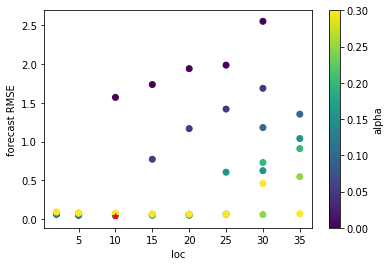

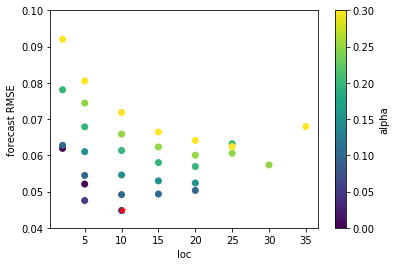

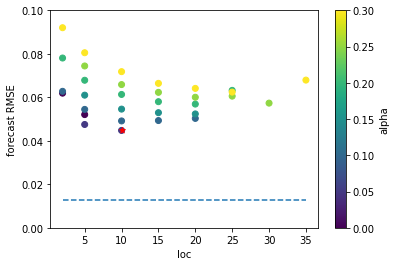

In [47]:
plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
# plt.xlim([55, 105])
plt.ylim([0.04, 0.1])
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_f, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_f],
            stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.plot(unique_stdrd_loc,
         np.min(smooth_rmse_f) *np.ones(unique_stdrd_loc.size),
         '--')
# plt.xlim([55, 105])
plt.ylim([0, 0.1])
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

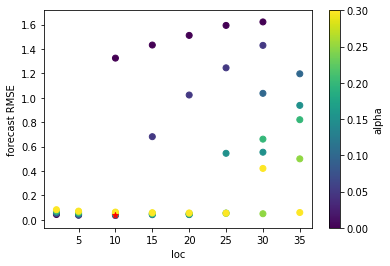

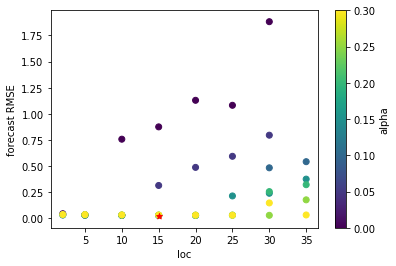

In [39]:
plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_fY, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_fY],
            stdrd_rmse_fY[stdrd_index_fY], marker='*', c='r')
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

plt.figure()
im = plt.scatter(stdrd_loc, stdrd_rmse_fX, c=stdrd_alpha)
cbar = plt.colorbar(im)
plt.scatter(stdrd_loc[stdrd_index_fX],
            stdrd_rmse_fX[stdrd_index_fX], marker='*', c='r')
# plt.xlim([55, 105])
# plt.ylim([0.45, 0.6])
plt.ylabel('forecast RMSE')
plt.xlabel('loc')
cbar.set_label('alpha')

In [52]:
smooth_alpha

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05])

(0, 0.1)

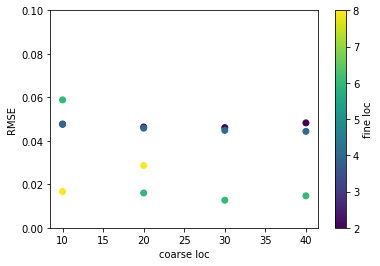

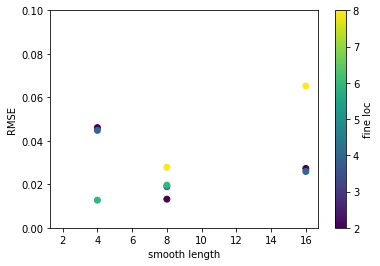

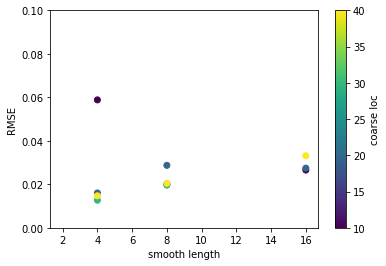

In [50]:
smooth_mask = smooth_smooth == smooth_smooth[smooth_index_f]
cloc_mask = smooth_cloc == smooth_cloc[smooth_index_f]
floc_mask = smooth_floc == smooth_floc[smooth_index_f]
alpha_mask = smooth_alpha == smooth_alpha[smooth_index_f]

plt.figure()
im = plt.scatter(smooth_cloc[np.logical_and(smooth_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(smooth_mask, alpha_mask)],
                 c=smooth_floc[np.logical_and(smooth_mask, alpha_mask)])
cbar = plt.colorbar(im)
plt.ylabel('RMSE')
plt.xlabel('coarse loc')
cbar.set_label('fine loc')
plt.ylim([0, 0.1])

plt.figure()
im = plt.scatter(smooth_smooth[np.logical_and(cloc_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(cloc_mask, alpha_mask)],
                 c=smooth_floc[np.logical_and(cloc_mask, alpha_mask)])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('fine loc')
plt.ylim([0, 0.1])


plt.figure()
im = plt.scatter(smooth_smooth[np.logical_and(floc_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(floc_mask, alpha_mask)],
                 c=smooth_cloc[np.logical_and(floc_mask, alpha_mask)])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('coarse loc')
plt.ylim([0, 0.1])


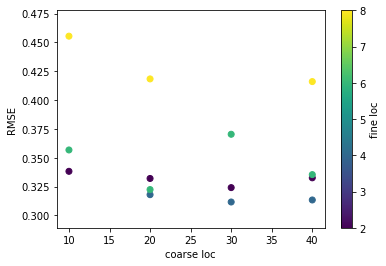

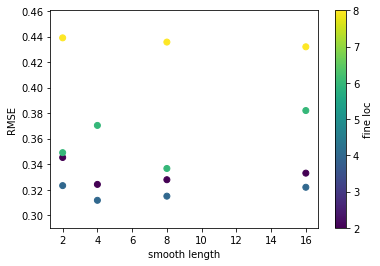

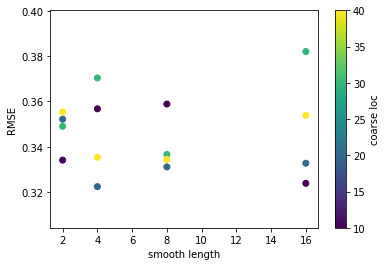

In [54]:
smooth_mask = smooth_smooth == smooth_smooth[smooth_index_f]
cloc_mask = smooth_cloc == smooth_cloc[smooth_index_f]
floc_mask = smooth_floc == smooth_floc[smooth_index_f]
alpha_mask = smooth_alpha != smooth_alpha[smooth_index_f]

plt.figure()
im = plt.scatter(smooth_cloc[np.logical_and(smooth_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(smooth_mask, alpha_mask)],
                 c=smooth_floc[np.logical_and(smooth_mask, alpha_mask)])
cbar = plt.colorbar(im)
plt.ylabel('RMSE')
plt.xlabel('coarse loc')
cbar.set_label('fine loc')
# plt.ylim([0, 0.1])

plt.figure()
im = plt.scatter(smooth_smooth[np.logical_and(cloc_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(cloc_mask, alpha_mask)],
                 c=smooth_floc[np.logical_and(cloc_mask, alpha_mask)])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('fine loc')
# plt.ylim([0, 0.1])


plt.figure()
im = plt.scatter(smooth_smooth[np.logical_and(floc_mask, alpha_mask)],
                 smooth_rmse_f[np.logical_and(floc_mask, alpha_mask)],
                 c=smooth_cloc[np.logical_and(floc_mask, alpha_mask)])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('coarse loc')
# plt.ylim([0, 0.1])


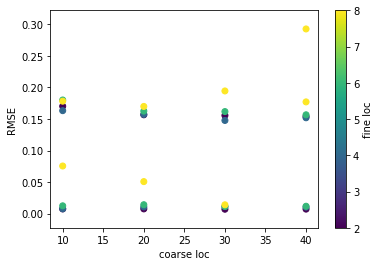

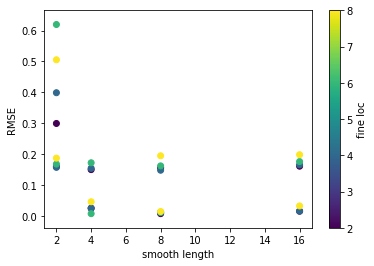

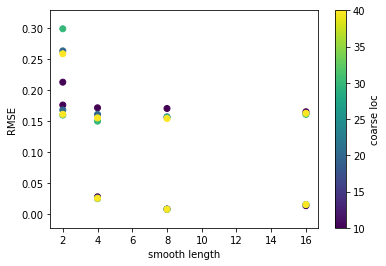

In [41]:
smooth_mask = smooth_smooth == smooth_smooth[smooth_index_fX]
cloc_mask = smooth_cloc == smooth_cloc[smooth_index_fX]
floc_mask = smooth_floc == smooth_floc[smooth_index_fX]

plt.figure()
im = plt.scatter(smooth_cloc[smooth_mask],
                 smooth_rmse_fX[smooth_mask],
                 c=smooth_floc[smooth_mask])
cbar = plt.colorbar(im)
plt.ylabel('RMSE')
plt.xlabel('coarse loc')
cbar.set_label('fine loc')

plt.figure()
im = plt.scatter(smooth_smooth[cloc_mask],
                 smooth_rmse_fX[cloc_mask],
                 c=smooth_floc[cloc_mask])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('fine loc')

plt.figure()
im = plt.scatter(smooth_smooth[floc_mask],
                 smooth_rmse_fX[floc_mask],
                 c=smooth_cloc[floc_mask])
cbar = plt.colorbar(im)
# plt.scatter(stdrd_loc[stdrd_index_f],
#             stdrd_rmse_f[stdrd_index_f], marker='*', c='r')
plt.ylabel('RMSE')
plt.xlabel('smooth length')
cbar.set_label('coarse loc')

In [66]:
temp_rmse_f.shape

(960, 1000)

In [172]:
stdrd_opt_path = stdrd_dirs_success[stdrd_index_f]
smooth_opt_path = smooth_dirs_success[smooth_index_f]

this_path = os.path.join(stdrd_opt_path, 'mu_f.nc')
stdrd_mu_f = xr.open_dataarray(this_path)
stdrd_mu_fX = utilities.window_sum_Z(stdrd_mu_f, I=I, alpha=alpha, beta=beta)
stdrd_mu_fY = stdrd_mu_f - stdrd_mu_fX
stdrd_rmse_f = np.sqrt(((stdrd_mu_f - Zgt_ts.sel(time=stdrd_mu_f.time))**2).mean(axis=0))
stdrd_rmse_fX = np.sqrt(((stdrd_mu_fX - Xgt_ts.sel(time=stdrd_mu_f.time))**2).mean(axis=0))
stdrd_rmse_fY = np.sqrt(((stdrd_mu_fY - Ygt_ts.sel(time=stdrd_mu_f.time))**2).mean(axis=0))

this_path = os.path.join(stdrd_opt_path, 'std_f.nc')
stdrd_std_f = xr.open_dataarray(this_path)
stdrd_std_f = np.sqrt((stdrd_std_f**2).mean(axis=0))

this_path = os.path.join(smooth_opt_path, 'mu_f.nc')
smooth_mu_f = xr.open_dataarray(this_path)
smooth_mu_fX = utilities.window_sum_Z(smooth_mu_f, I=I, alpha=alpha, beta=beta)
smooth_mu_fY = smooth_mu_f - smooth_mu_fX
smooth_rmse_f = np.sqrt(((smooth_mu_f - Zgt_ts.sel(time=smooth_mu_f.time))**2).mean(axis=0))
smooth_rmse_fX = np.sqrt(((smooth_mu_fX - Xgt_ts.sel(time=smooth_mu_f.time))**2).mean(axis=0))
smooth_rmse_fY = np.sqrt(((smooth_mu_fY - Ygt_ts.sel(time=smooth_mu_f.time))**2).mean(axis=0))

this_path = os.path.join(smooth_opt_path, 'std_f.nc')
smooth_std_f = xr.open_dataarray(this_path)
smooth_std_f = np.sqrt((smooth_std_f**2).mean(axis=0))

Text(0.5, 1.0, 'Y RMSE')

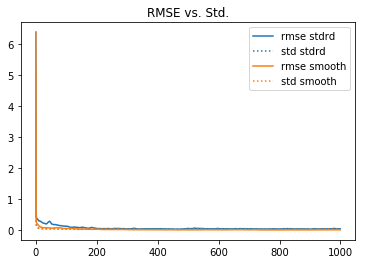

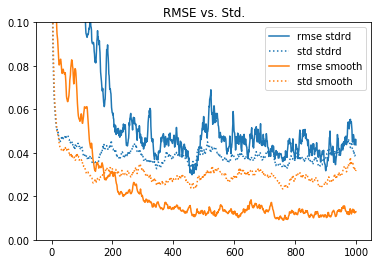

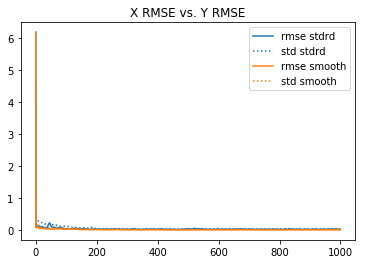

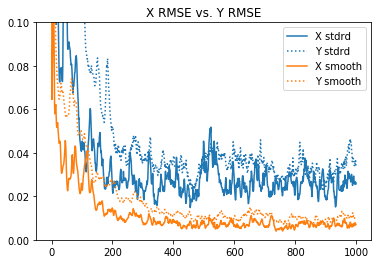

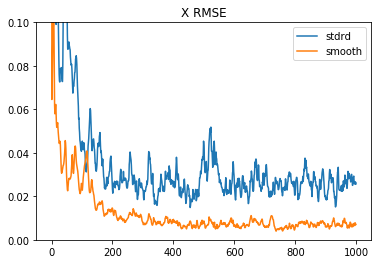

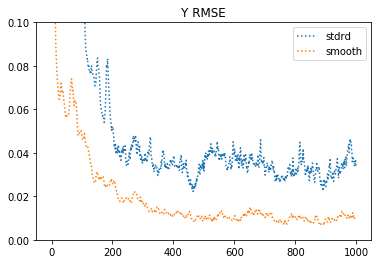

In [284]:
plt.figure()
plt.plot(stdrd_rmse_f, color='C0')
plt.plot(stdrd_std_f, color='C0', linestyle=':')
plt.plot(smooth_rmse_f, color='C1')
plt.plot(smooth_std_f, color='C1', linestyle=':')
plt.legend(['rmse stdrd', 'std stdrd',
            'rmse smooth', 'std smooth'])
plt.title('RMSE vs. Std.')

plt.figure()
plt.plot(stdrd_rmse_f, color='C0')
plt.plot(stdrd_std_f, color='C0', linestyle=':')

plt.plot(smooth_rmse_f, color='C1')
plt.plot(smooth_std_f, color='C1', linestyle=':')
plt.ylim([0, 0.1])
plt.legend(['rmse stdrd', 'std stdrd',
            'rmse smooth', 'std smooth'])
plt.title('RMSE vs. Std.')

plt.figure()
plt.plot(stdrd_rmse_fX, color='C0')
plt.plot(stdrd_rmse_fY, color='C0', linestyle=':')
plt.plot(smooth_rmse_fX, color='C1')
plt.plot(smooth_rmse_fY, color='C1', linestyle=':')
plt.legend(['rmse stdrd', 'std stdrd',
            'rmse smooth', 'std smooth'])
plt.title('X RMSE vs. Y RMSE')


plt.figure()
plt.plot(stdrd_rmse_fX, color='C0')
plt.plot(stdrd_rmse_fY, color='C0', linestyle=':')

plt.plot(smooth_rmse_fX, color='C1')
plt.plot(smooth_rmse_fY, color='C1', linestyle=':')
plt.ylim([0, 0.1])
plt.legend(['X stdrd', 'Y stdrd',
            'X smooth', 'Y smooth'])
plt.title('X RMSE vs. Y RMSE')

plt.figure()
plt.plot(stdrd_rmse_fX, color='C0')
# plt.plot(stdrd_rmse_fY, color='C0', linestyle=':')

plt.plot(smooth_rmse_fX, color='C1')
# plt.plot(smooth_rmse_fY, color='C1', linestyle=':')
plt.ylim([0, 0.1])
plt.legend(['stdrd',
            'smooth'])
plt.title('X RMSE')

plt.figure()
# plt.plot(stdrd_rmse_fX, color='C0')
plt.plot(stdrd_rmse_fY, color='C0', linestyle=':')

# plt.plot(smooth_rmse_fX, color='C1')
plt.plot(smooth_rmse_fY, color='C1', linestyle=':')
plt.ylim([0, 0.1])
plt.legend(['stdrd',
            'smooth'])
plt.title('Y RMSE')

In [175]:
stdrd_rmse_fY[Tspin_index:].mean()

<xarray.DataArray ()>
array(0.034307)

In [176]:
smooth_rmse_fY[Tspin_index:].mean()

<xarray.DataArray ()>
array(0.01014)

In [177]:
smooth_rmse_f

<xarray.DataArray (time: 1000)>
array([6.376155, 0.311265, 0.24955 , ..., 0.01291 , 0.012858, 0.012899])
Coordinates:
  * time     (time) float64 0.05 0.1 0.15 0.2 0.25 ... 49.85 49.9 49.95 50.0

In [178]:
this_Zgt = Zgt_ts.sel(time=smooth_mu_f.time).values
this_Xgt = Xgt_ts.sel(time=smooth_mu_f.time).values
this_Ygt = Ygt_ts.sel(time=smooth_mu_f.time).values
this_t = smooth_mu_f.time.values

In [264]:
err_sm_len = 20

stdrd_abs_win_err_X = np.abs(stdrd_mu_fX - this_Xgt)
stdrd_abs_win_err_X = ndimage.uniform_filter1d(
    stdrd_abs_win_err_X, err_sm_len, axis=0, mode='wrap')

stdrd_abs_win_err_Y = np.abs(stdrd_mu_fY - this_Ygt)
stdrd_abs_win_err_Y = ndimage.uniform_filter1d(
    stdrd_abs_win_err_Y, err_sm_len, axis=0, mode='wrap')

smooth_abs_win_err_X = np.abs(smooth_mu_fX - this_Xgt)
smooth_abs_win_err_X = ndimage.uniform_filter1d(
    smooth_abs_win_err_X, err_sm_len, axis=0, mode='wrap')

smooth_abs_win_err_Y = np.abs(smooth_mu_fY - this_Ygt)
smooth_abs_win_err_Y = ndimage.uniform_filter1d(
    smooth_abs_win_err_Y, err_sm_len, axis=0, mode='wrap')

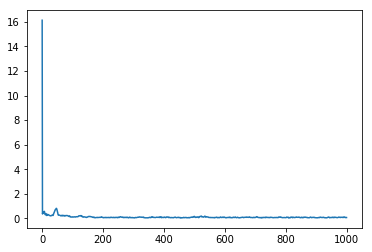

In [273]:
plt.figure()
plt.plot(np.max([stdrd_abs_win_err_X.max(axis=0), smooth_abs_win_err_X.max(axis=0)], axis=0))

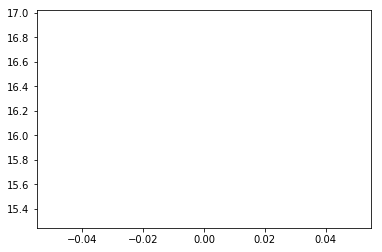

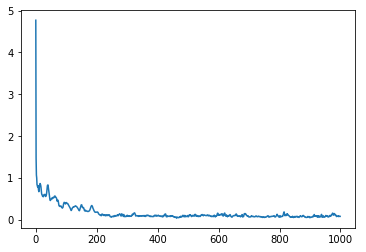

In [270]:
plt.figure()
plt.plot(np.max([stdrd_abs_win_err_X.max(axis=0), stdrd_abs_win_err_Y.max(axis=0)]))

plt.figure()
plt.plot(stdrd_abs_win_err_Y.max(axis=0))

(0, 0.08070574015903768)

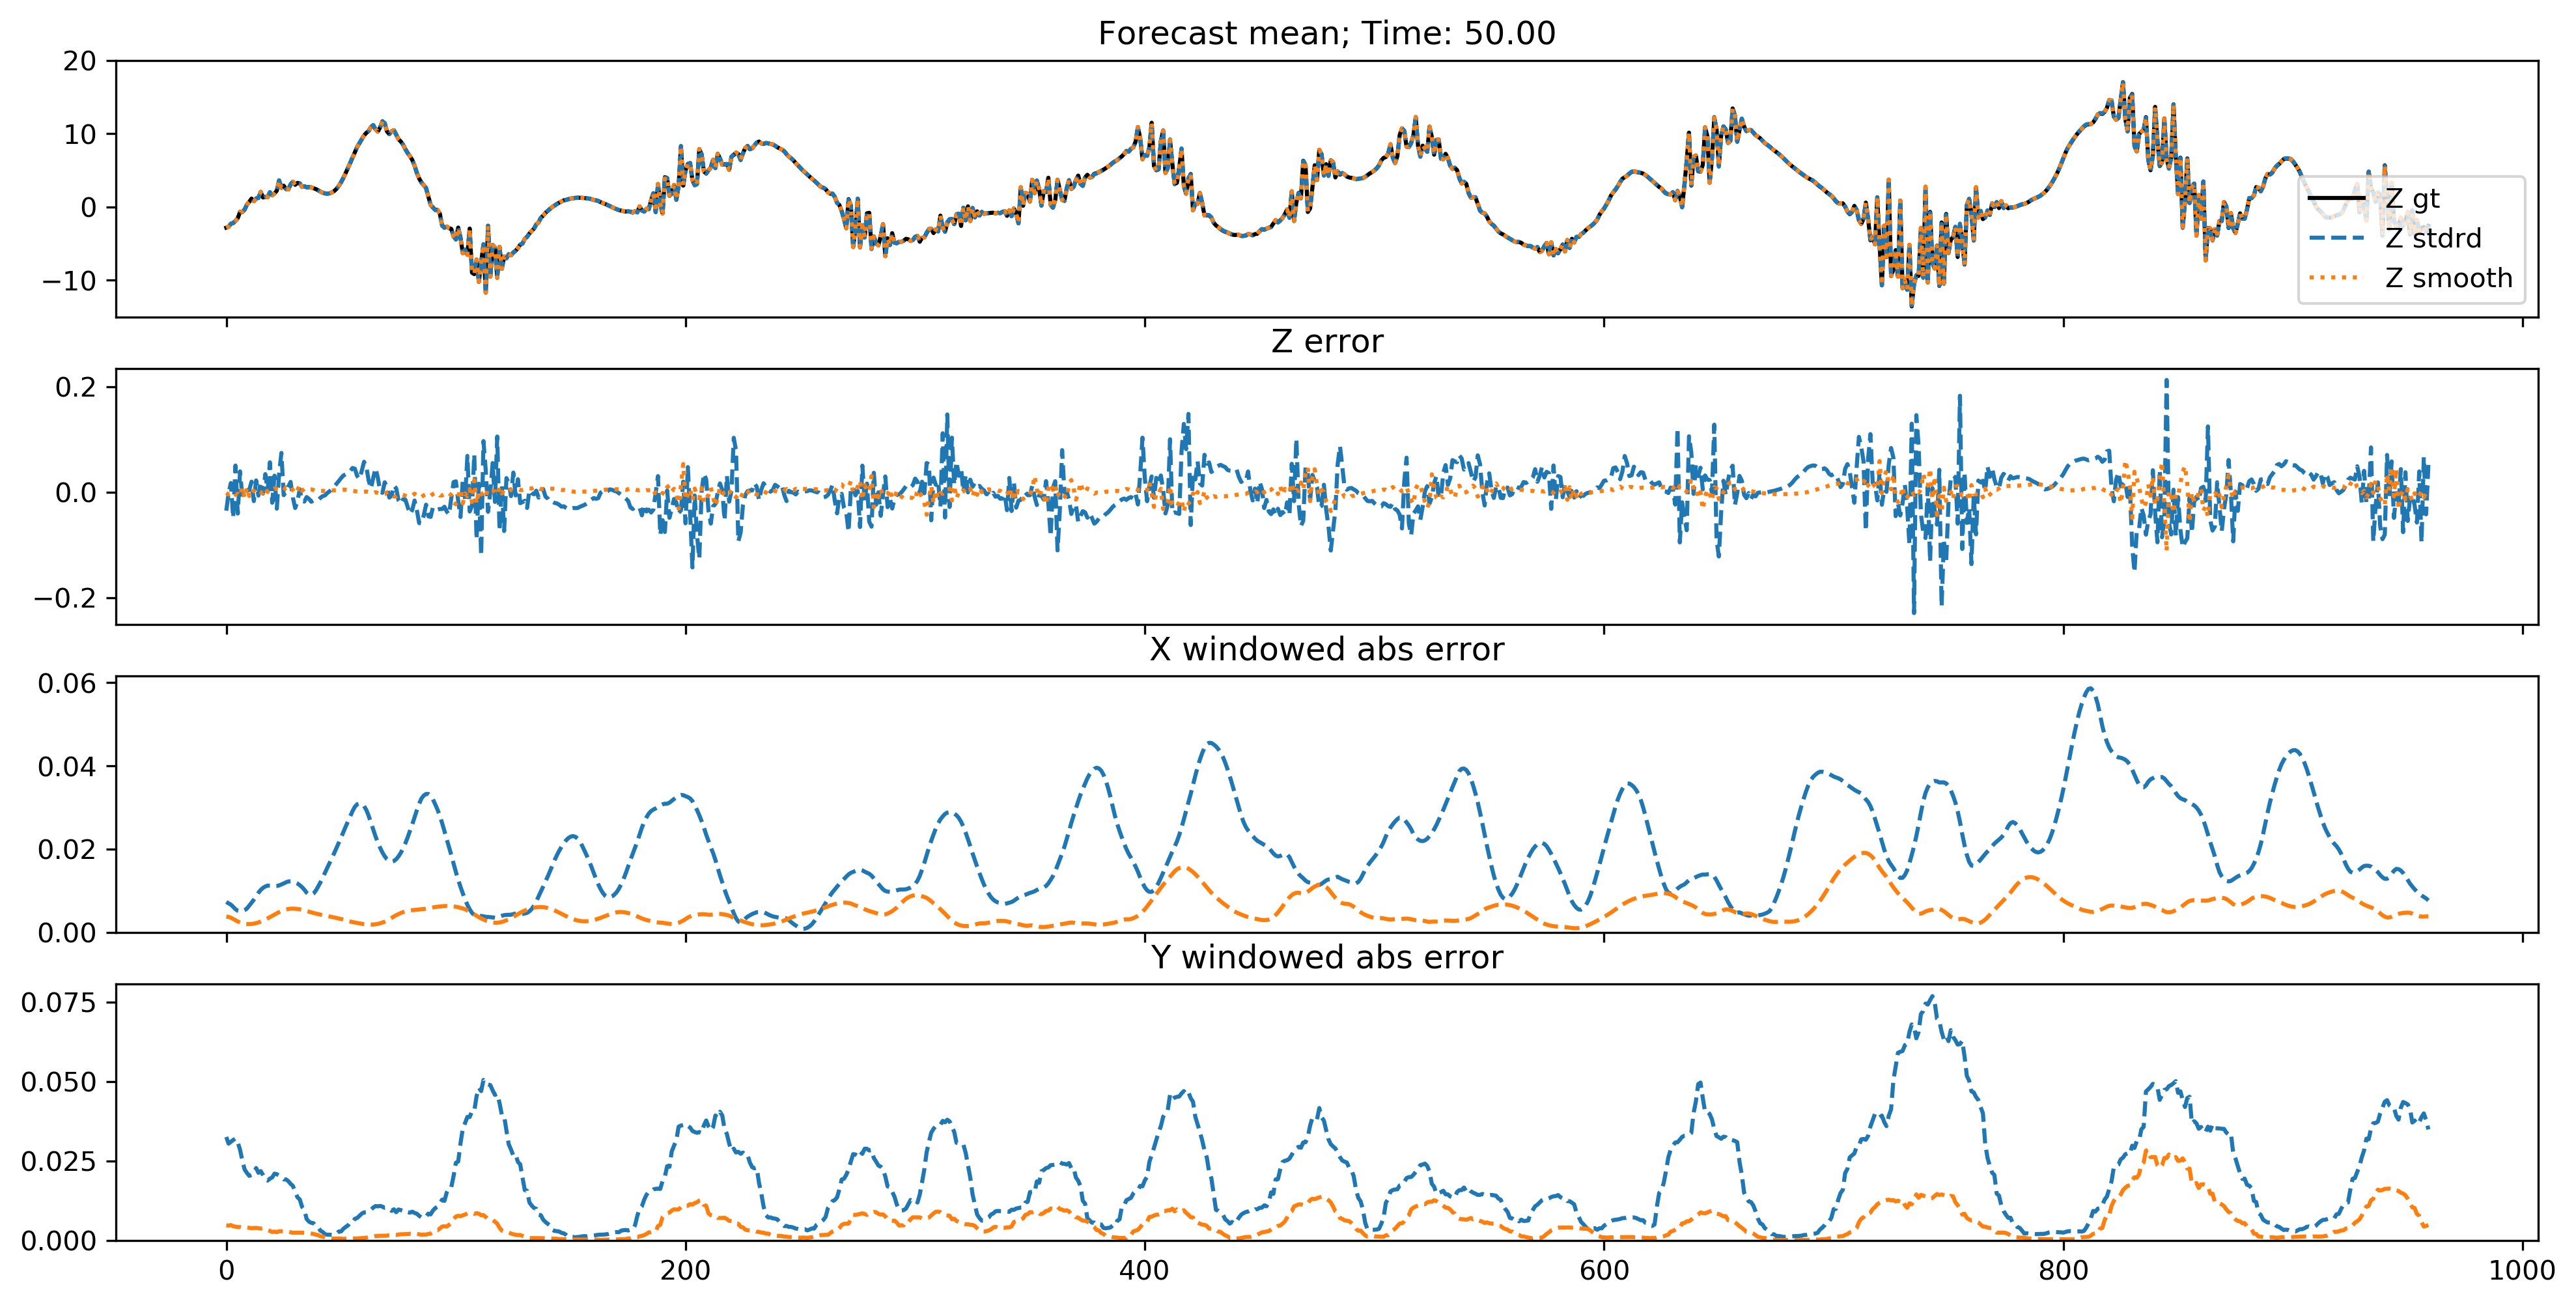

In [274]:
ii = -1
    
fig, ax = plt.subplots(nrows=4, sharex=True,
                       figsize=figsize, dpi=dpi)
ax[0].plot(this_Zgt[:, ii], color='k')
ax[0].plot(stdrd_mu_f[:, ii], color='C0', linestyle=stdrd_line)
ax[0].plot(smooth_mu_f[:, ii], color='C1', linestyle=smooth_line)
ax[0].legend(['Z gt', 'Z stdrd', 'Z smooth'],loc='lower right')
ax[0].set_ylim([-15, 20])
ax[0].set_title(f'Forecast mean; Time: {this_t[ii]:0.2f}')

this_error = stdrd_mu_f[:, ii] - this_Zgt[:, ii]
ax[1].plot(this_error, color='C0', linestyle=stdrd_line)
this_error = smooth_mu_f[:, ii] - this_Zgt[:, ii]
ax[1].plot(this_error, color='C1', linestyle=smooth_line)
ax[1].set_title('Z error')

# this_error = ndimage.uniform_filter(np.abs(stdrd_mu_fX[:, ii] - this_Xgt[:, ii]), err_sm_len, mode='wrap')
this_error = stdrd_abs_win_err_X[:, ii]
ymax = this_error.max()
ax[2].plot(this_error, color='C0', linestyle='--')
# this_error = ndimage.uniform_filter(np.abs(smooth_mu_fX[:, ii] - this_Xgt[:, ii]), err_sm_len, mode='wrap')
this_error = smooth_abs_win_err_X[:, ii]
ymax = np.max([ymax, this_error.max()])
ymax = ymax* 1.05
if ymax/ymax_lastX < 0.75 or ymax/ymax_lastX > 1.25:
    ymax_lastX = ymax
ax[2].plot(this_error, color='C1', linestyle='--')
ax[2].set_ylim([0, ymax_lastX])
ax[2].set_title('X windowed abs error')

# this_error = ndimage.uniform_filter(np.abs(stdrd_mu_fY[:, ii] - this_Ygt[:, ii]), err_sm_len, mode='wrap')
this_error = stdrd_abs_win_err_Y[:, ii]
ymax = this_error.max()
ax[3].plot(this_error, color='C0', linestyle='--')
# this_error = ndimage.uniform_filter(np.abs(smooth_mu_fY[:, ii] - this_Ygt[:, ii]), err_sm_len, mode='wrap')
this_error = smooth_abs_win_err_Y[:, ii]
ymax = np.max([ymax, this_error.max()])
ymax = ymax* 1.05
if ymax/ymax_lastY < 0.75 or ymax/ymax_lastY > 1.25:
    ymax_lastY = ymax
ax[3].plot(this_error, color='C1', linestyle='--')
ax[3].set_title('Y windowed abs error')
ax[3].set_ylim([0, ymax_lastY])

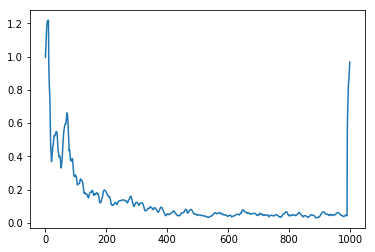

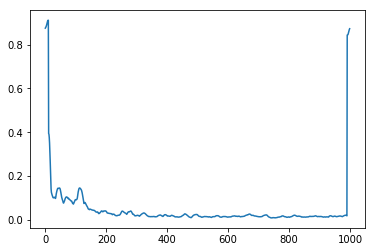

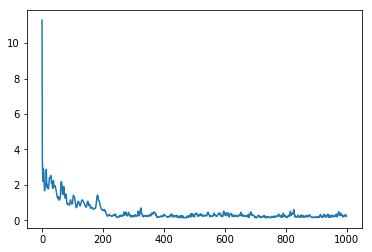

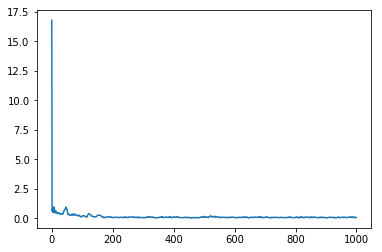

In [233]:
plt.figure()
plt.plot(np.max(smooth_abs_win_err_Y, axis=0))

plt.figure()
plt.plot(np.max(smooth_abs_win_err_X, axis=0))

plt.figure()
plt.plot(np.max(stdrd_abs_win_err_Y, axis=0))

plt.figure()
plt.plot(np.max(stdrd_abs_win_err_X, axis=0))

In [280]:
figsize = 2*plt.figaspect(1/2)
dpi = 150

stdrd_line = '--'
smooth_line = ':'

y_max_change = 0.75

actual_alpha = 0.3
ymax_lastX = 100
ymax_lastY = 100
for ii in range(this_t.size):
    ii *= 1
    
    fig, ax = plt.subplots(nrows=4, sharex=True,
                       figsize=figsize, dpi=dpi)
    ax[0].plot(this_Zgt[:, ii], color='k')
    ax[0].plot(stdrd_mu_f[:, ii], color='C0', linestyle=stdrd_line)
    ax[0].plot(smooth_mu_f[:, ii], color='C1', linestyle=smooth_line)
    ax[0].legend(['Z gt', 'Z stdrd', 'Z smooth'],loc='lower right')
    ax[0].set_ylim([-15, 20])
    ax[0].set_title(f'Forecast mean; Time: {this_t[ii]:0.2f}')

    this_error = stdrd_mu_f[:, ii] - this_Zgt[:, ii]
    ax[1].plot(this_error, color='C0', linestyle=stdrd_line)
    this_error = smooth_mu_f[:, ii] - this_Zgt[:, ii]
    ax[1].plot(this_error, color='C1', linestyle=smooth_line)
    ax[1].set_title('Z error')

    # this_error = ndimage.uniform_filter(np.abs(stdrd_mu_fX[:, ii] - this_Xgt[:, ii]), err_sm_len, mode='wrap')
    this_error = stdrd_abs_win_err_X[:, ii]
    ymax = this_error.max()
    ax[2].plot(this_error, color='C0', linestyle='--')
    # this_error = ndimage.uniform_filter(np.abs(smooth_mu_fX[:, ii] - this_Xgt[:, ii]), err_sm_len, mode='wrap')
    this_error = smooth_abs_win_err_X[:, ii]
    ymax = np.max([ymax, this_error.max()])
    ymax = ymax* 1.05
    if np.abs(ymax/ymax_lastX - 1) > y_max_change:
        ymax_lastX = ymax
    ax[2].plot(this_error, color='C1', linestyle='--')
    ax[2].set_ylim([0, ymax_lastX])
    ax[2].set_title('X windowed abs error')

    # this_error = ndimage.uniform_filter(np.abs(stdrd_mu_fY[:, ii] - this_Ygt[:, ii]), err_sm_len, mode='wrap')
    this_error = stdrd_abs_win_err_Y[:, ii]
    ymax = this_error.max()
    ax[3].plot(this_error, color='C0', linestyle='--')
    # this_error = ndimage.uniform_filter(np.abs(smooth_mu_fY[:, ii] - this_Ygt[:, ii]), err_sm_len, mode='wrap')
    this_error = smooth_abs_win_err_Y[:, ii]
    ymax = np.max([ymax, this_error.max()])
    ymax = ymax* 1.05
    if np.abs(ymax/ymax_lastY - 1) > y_max_change:
        ymax_lastY = ymax
    ax[3].plot(this_error, color='C1', linestyle='--')
    ax[3].set_title('Y windowed abs error')
    ax[3].set_ylim([0, ymax_lastY])
    
    plt.savefig(f'Error_figs/zfig_{ii:05}', dpi=dpi)
    plt.close('all')

In [192]:
10**np.floor(np.log10(0.05))

0.01

In [ ]:
np.ceil()

In [87]:
smooth_mu_f.shape

(960, 1000)

In [69]:
stdrd_mu_f.shape

(960, 1000)

In [64]:
smooth_opt_path

'/Users/harty/Documents/python_code/multi_loc/notebooks/dt_05_2/dense_obs/smooth_loc/inf_0001_smooth_0000_floc_0002_cloc_0002'

In [27]:
importlib.reload(assimilate)
importlib.reload(utilities)

mu_f = []
mu_a = []

std_f = []
std_a = []

rmse_array_f = np.ones([alpha_range.size, loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

stdrd_dir = os.path.join(tune_dir, stdrd_dir)
smooth_dir = os.path.join(tune_dir, smooth_dir)

for alpha_count, this_alpha in enumerate(alpha_range):
    for loc_count, this_loc in enumerate(loc_range):
        this_folder_name = f'inf_{alpha_count:04}_loc_{loc_count:04}'
        this_dir_name = os.path.join(stdrd_dir, this_folder_name)
#         if not os.path.exists(this_dir_name):
#             os.mkdir(this_dir_name)
        print('alpha: ', this_alpha, '; loc: ', this_loc)
        print('alpha_count: ', alpha_count, ': loc_count: ', loc_count)

#         rho_Zc = np.arange(Nz)
#         rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
#         rho_Zc = np.exp(-(rho_Zc**2)/(2*this_loc**2))
#         rho_Zc = sp.linalg.circulant(rho_Zc)
        
#         this_path = os.path.join(this_dir_name, 'rho0z')
#         np.save(this_path, this_loc)
        
#         this_path = os.path.join(this_dir_name, 'alpha')
#         np.save(this_path, this_alpha)

#         cycle_dict = {'Z0ens': Z0ens,
#                       'Zobs_ts': Zobs_ts,
#                       'Rz': Rz, 'Hz': Hz,
#                       'Tkf': Tkf,
#                       'dt_kf': dt_kf,
#                       'dt_rk': dt_trial_rk,
#                       'rho_Z': rho_Zc,
#                       'rho0_Z': this_loc,
#                       'alpha': this_alpha}
        try:
            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            print(this_path)
            mu_f.append(xr.open_dataarray(this_path))
            
            this_path = os.path.join(this_dir_name, 'mu_a.nc')
            print(this_path)
            mu_a.append(xr.open_dataarray(this_path))
            
#             this_path = os.path.join(this_dir_name, 'std_f.nc')
#             std_f.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'mu_a.nc')
#             mu_a.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'std_a.nc')
#             std_a.to_netcdf(this_path)


#             rmse_array_f[alpha_count, loc_count] = (np.sqrt(
#                 ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             rmse_array_a[alpha_count, loc_count] = (np.sqrt(
#                 ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             std_array_f[alpha_count, loc_count] = (np.sqrt((std_f**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
#             std_array_a[alpha_count, loc_count] = (np.sqrt((std_a**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
        except:
            print(this_dir_name, ' has failed.')
        

NameError: name 'alpha_range' is not defined

In [56]:
importlib.reload(assimilate)
importlib.reload(utilities)


rmse_array_f = np.ones([smooth_range.size,
                        fine_loc_range.size,
                        coarse_loc_range.size]) * np.nan
std_array_f = rmse_array_f.copy()

rmse_array_a = rmse_array_f.copy()
std_array_a = rmse_array_f.copy()

smooth_dir = os.path.join(tune_dir, 'smooth_loc')
if not os.path.exists(smooth_dir):
    os.mkdir(smooth_dir)

for smooth_count, this_smooth in enumerate(smooth_range):
    for fine_loc_count, this_fine_loc in enumerate(fine_loc_range):
        for coarse_loc_count, this_coarse_loc in enumerate(coarse_loc_range):
            this_folder_name = f'inf_{alpha_count:04}_smooth_{smooth_count:04}'
            this_folder_name += f'_floc_{fine_loc_count:04}_cloc_{coarse_loc_count:04}'
            this_dir_name = os.path.join(smooth_dir, this_folder_name)
#             if not os.path.exists(this_dir_name):
#                 os.mkdir(this_dir_name)
            print('alpha: ', this_alpha, '; smooth: ', this_smooth)
            print('fine_loc: ', this_fine_loc, '; coarse_loc: ', this_coarse_loc)
            print(this_dir_name)
            
#             rho_Zf = np.arange(Nz)
#             rho_Zf = np.minimum(np.abs(Nz - rho_Zf)%Nz, rho_Zf)
#             rho_Zf = np.exp(-(rho_Zf**2)/(2*this_fine_loc**2))
#             rho_Zf = sp.linalg.circulant(rho_Zf)

#             rho_Zc = np.arange(Nz)
#             rho_Zc = np.minimum(np.abs(Nz - rho_Zc)%Nz, rho_Zc)
#             rho_Zc = np.exp(-(rho_Zc**2)/(2*this_coarse_loc**2))
#             rho_Zc = sp.linalg.circulant(rho_Zc)

#             this_path = os.path.join(this_dir_name, 'rho0f')
#             np.save(this_path, this_fine_loc)
            
#             this_path = os.path.join(this_dir_name, 'rho0c')
#             np.save(this_path, this_coarse_loc)

#             this_path = os.path.join(this_dir_name, 'alpha')
#             np.save(this_path, this_alpha)
            
#             this_path = os.path.join(this_dir_name, 'smooth')
#             np.save(this_path, this_smooth)
            
#             this_path = os.path.join(this_dir_name, 'N_laml')
#             np.save(this_path, N_laml)

#             cycle_dict = {'Z0ens': Z0ens,
#                           'Zobs_ts': Zobs_ts,
#                           'Rz': Rz, 'Hz': Hz,
#                           'Tkf': Tkf,
#                           'dt_kf': dt_kf,
#                           'dt_rk': dt_trial_rk,
#                           'rho_Zc': rho_Zc,
#                           'rho_Zf': rho_Zf,
#                           'N_laml': N_laml,
#                           'smooth_len': this_smooth,
#                           'alpha': this_alpha}
#             returned_dict = assimilate.cycle_KF_LM3_smooth(**cycle_dict)
#             mu_f = returned_dict['mu_f']
#             std_f = returned_dict['std_f']

#             mu_a = returned_dict['mu_a']
#             std_a = returned_dict['std_a']

            this_path = os.path.join(this_dir_name, 'mu_f.nc')
            mu_f = xr.open_dataarray(this_path)

#             this_path = os.path.join(this_dir_name, 'std_f.nc')
#             std_f.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'mu_a.nc')
#             mu_a.to_netcdf(this_path)

#             this_path = os.path.join(this_dir_name, 'std_a.nc')
#             std_a.to_netcdf(this_path)


            rmse_array_f[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
                ((mu_f - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
                                          .isel(time=slice(Tspin_index, None)).mean())
#             rmse_array_a[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt(
#                 ((mu_a - Zgt_ts.sel(time=mu_f.time))**2).mean(axis=0))
#                                           .isel(time=slice(Tspin_index, None)).mean())
#             std_array_f[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_f**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
#             std_array_a[smooth_count, fine_loc_count, coarse_loc_count] = (np.sqrt((std_a**2).mean(axis=0))
#                                                   .isel(time=slice(Tspin_index, None)).mean())
            print('rmse_f: ', rmse_array_f[smooth_count, fine_loc_count, coarse_loc_count])
#             print('rmse_a: ', rmse_array_a[smooth_count, fine_loc_count, coarse_loc_count])

NameError: name 'smooth_range' is not defined

In [ ]:
smooth_di

In [54]:
this_path = os.path.join(stdrd_dir, 'rmse_array_f.npy')
rmse_array_f_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'std_array_f.npy')
std_array_f_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'rmse_array_a.npy')
rmse_array_a_stdrd = np.load(this_path)

this_path = os.path.join(stdrd_dir, 'std_array_a.npy')
std_array_a_stdrd = np.load(this_path)



this_path = os.path.join(smooth_dir, 'rmse_array_f.npy')
rmse_array_f_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'std_array_f.npy')
std_array_f_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'rmse_array_a.npy')
rmse_array_a_smooth = np.load(this_path)

this_path = os.path.join(smooth_dir, 'std_array_a.npy')
std_array_a_smooth = np.load(this_path)

In [55]:
rmse_array_f_smooth

array([[[0.56269031, 0.57603408, 0.57749956, 0.57921801],
        [0.51864102, 0.52250652, 0.52307351, 0.52792226],
        [0.50916376, 0.50714987, 0.49929198, 0.49476525],
        [0.4900093 , 0.4883283 , 0.49611626, 0.49494184]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan],
      

In [29]:
np.unravel_index(rmse_array_f.argmin(), rmse_array_f.shape)

(3, 7)

In [37]:
alpha_range[3]

0.04

Text(0.5, 0, 'loc')

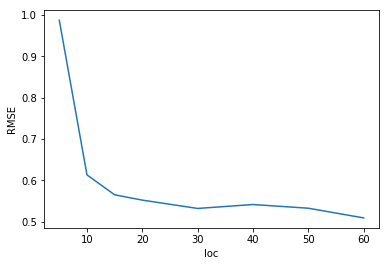

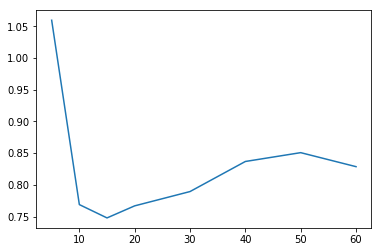

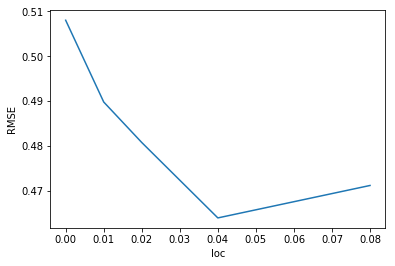

In [38]:
plt.figure()
plt.plot(loc_range, rmse_array_f[3, :])
plt.ylabel('RMSE')
plt.xlabel('loc')

plt.figure()
plt.plot(loc_range, rmse_array_f[3, :]
         /((1 + alpha_range[3]) * std_array_f[3, :]))

plt.figure()
plt.plot(alpha_range, rmse_array_a[:, 7])
plt.ylabel('RMSE')
plt.xlabel('loc')

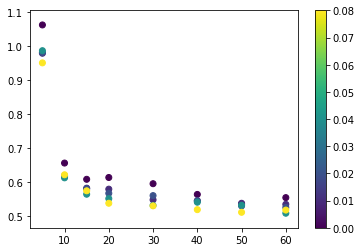

In [49]:
loc_array = np.repeat(loc_range[None, :], alpha_range.size, 0)
alpha_array = np.repeat(alpha_range[:, None], loc_range.size, -1)

plt.figure()
im = plt.scatter(
    loc_array.T,
    rmse_array_f.T,
    c=alpha_array.T)
plt.colorbar(im)

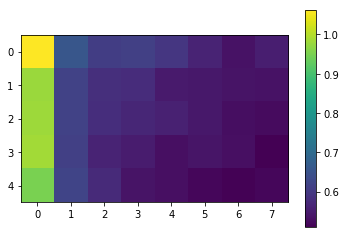

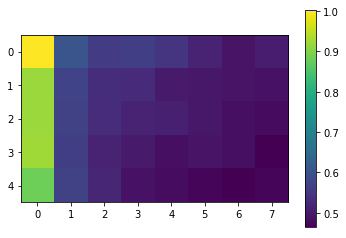

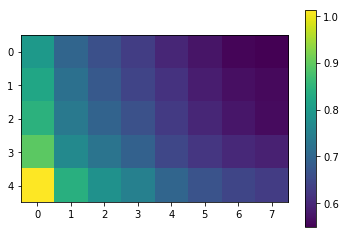

In [27]:
imshow(rmse_array_f)
imshow(rmse_array_a)

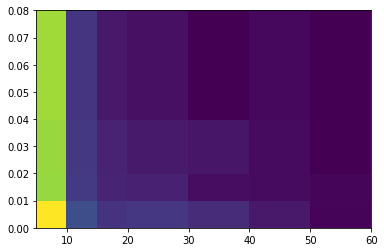

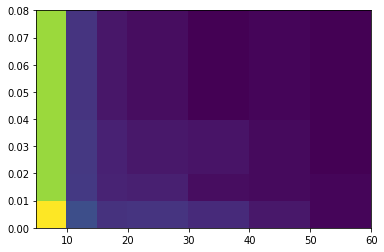

In [22]:
plt.figure()
plt.pcolormesh(loc_range,
               alpha_range,
               rmse_array_f)
plt.figure()
plt.pcolormesh(loc_range,
               alpha_range,
               rmse_array_a)

In [23]:
alpha_diff = np.diff(alpha_range)
alpha_plot = alpha_range - alpha_diff
# alpha_plot = np.concatenate(
#     [alpha_plot,
#      [alpha_range[-1] + alpha_diff[-1]]])

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [18]:
alpha_diff

array([0.01, 0.01, 0.02, 0.04])

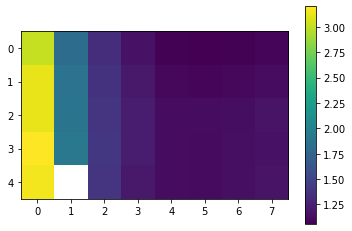

In [19]:
imshow(rmse_array_a)

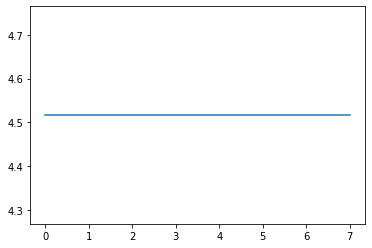

In [20]:
plt.figure()
plt.plot(rmse_array_f[0])

TypeError: Invalid shape (8,) for image data

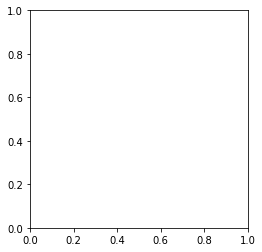

In [21]:
imshow(rmse_array_f[0])

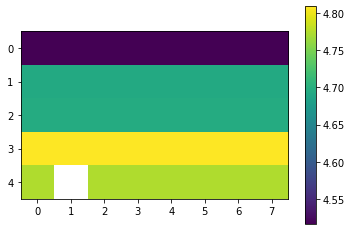

In [22]:
imshow(rmse_array_f)

In [25]:
mu_f[0].time

<xarray.DataArray 'time' (time: 1000)>
array([ 0.05,  0.1 ,  0.15, ..., 49.9 , 49.95, 50.  ])
Coordinates:
  * time     (time) float64 0.05 0.1 0.15 0.2 0.25 ... 49.85 49.9 49.95 50.0

In [21]:
this = mu_f[1]

In [ ]:
this = mu_f

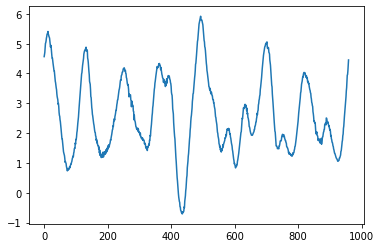

In [26]:
plt.figure()
plt.plot(this.isel(time=-1))